In [1]:
from funcs import *
% matplotlib inline

Using TensorFlow backend.


# Data

In [2]:
df = pd.read_excel('serieses.xlsx')

# US Federal effective rate

In [76]:
tf_ef_r = df.iloc[18, 1:].copy()
tf_ef_r.index = pd.DatetimeIndex(start='1954-07', end='2015-06', freq='M')

Results of Dickey-Fuller Test:
Test Statistic                  -2.682761
p-value                          0.077069
#Lags Used                      17.000000
Number of Observations Used    713.000000
Critical Value (1%)             -3.439555
Critical Value (5%)             -2.865602
Critical Value (10%)            -2.568933
dtype: float64


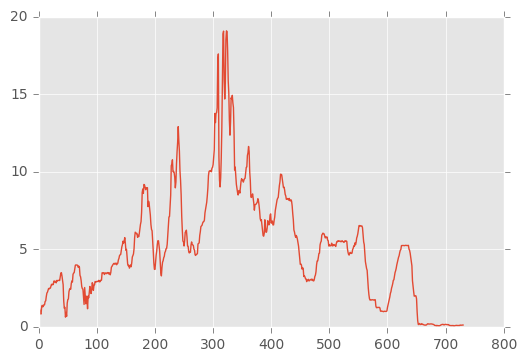

In [78]:
test_stationarity(tf_ef_r)

Results of Dickey-Fuller Test:
Test Statistic                -5.984594e+00
p-value                        1.804735e-07
#Lags Used                     1.800000e+01
Number of Observations Used    7.110000e+02
Critical Value (5%)           -2.865614e+00
Critical Value (1%)           -3.439581e+00
Critical Value (10%)          -2.568939e+00
dtype: float64


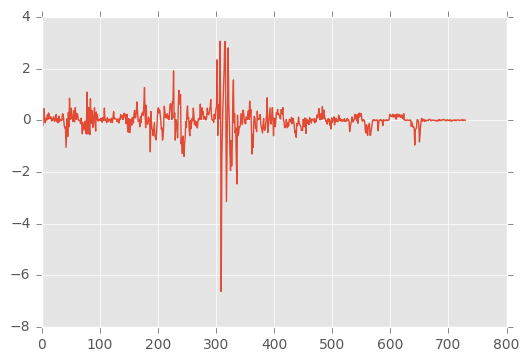

In [5]:
test_stationarity(diff_series(tf_ef_r))

In [79]:
train = tf_ef_r[:723]
test = tf_ef_r[723:]

### ARIMA

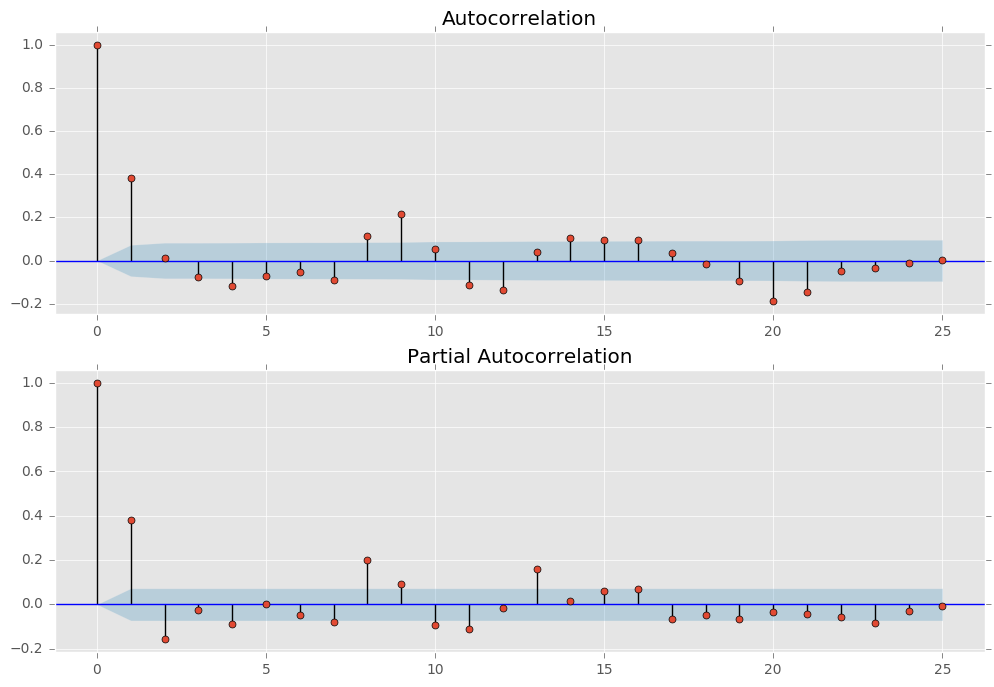

In [7]:
correlogram(diff_series(tf_ef_r))

In [8]:
model = ARIMA(np.array(train), order=(2,1,1)).fit(trend='nc')
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  722
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -482.677
Method:                       css-mle   S.D. of innovations              0.472
Date:                Thu, 26 Jan 2017   AIC                            973.353
Time:                        13:13:52   BIC                            991.682
Sample:                             1   HQIC                           980.428
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y      0.9107      0.161      5.662      0.000         0.595     1.226
ar.L2.D.y     -0.3278      0.059     -5.600      0.000        -0.443    -0.213
ma.L1.D.y     -0.4868      0.168     -2.905      0.0

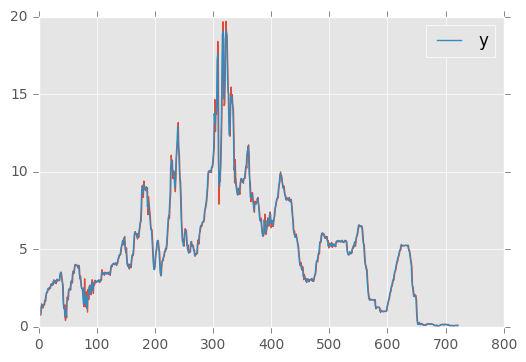

In [9]:
model.plot_predict()
plt.show()

In [10]:
forc_arima = model.forecast(len(test))

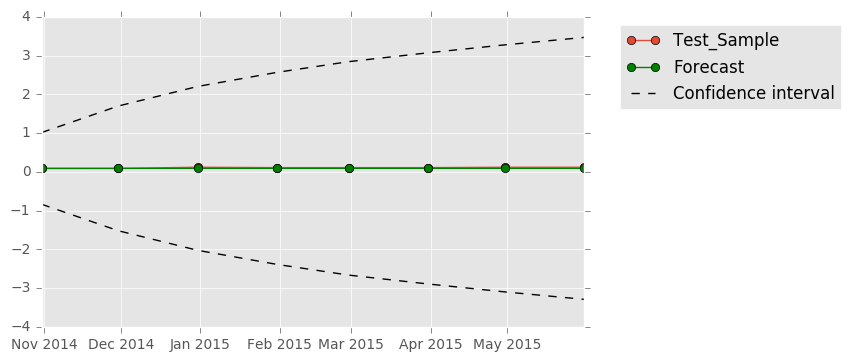

In [45]:
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.05,1))

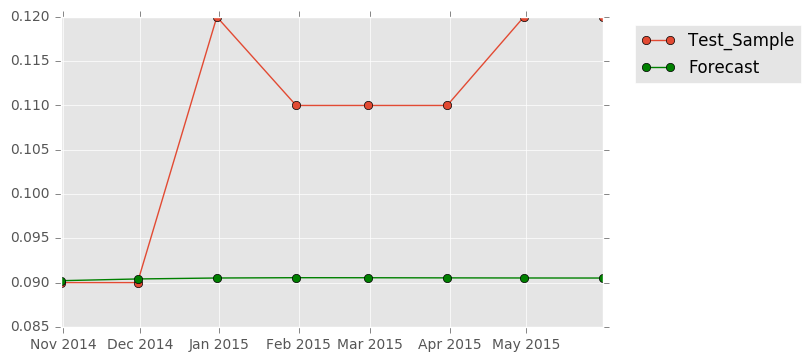

In [44]:
plot_forecast_out_only(test, forc_arima, conf_int=False, bbox_loc=(1.38,1))

In [52]:
errors_out_sample(test, forc_arima[0])

{'MAE': 0.018429207085006928, 'MSE': 0.00046788226060878258}

### ANN

In [99]:
train_nn = create_df_for_nn(tf_ef_r, 2).loc[:'2014-09-30', :]

In [110]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [116]:
nn = assemble_model(2)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 19.4075
Epoch 2/100
1s - loss: 12.1255
Epoch 3/100
1s - loss: 10.1788
Epoch 4/100
1s - loss: 8.3927
Epoch 5/100
0s - loss: 6.8455
Epoch 6/100
1s - loss: 6.0549
Epoch 7/100
1s - loss: 5.1777
Epoch 8/100
1s - loss: 5.1723
Epoch 9/100
1s - loss: 4.5537
Epoch 10/100
1s - loss: 4.2062
Epoch 11/100
1s - loss: 4.3369
Epoch 12/100
1s - loss: 4.0420
Epoch 13/100
1s - loss: 3.9262
Epoch 14/100
1s - loss: 4.1562
Epoch 15/100
1s - loss: 3.3575
Epoch 16/100
1s - loss: 3.6048
Epoch 17/100
1s - loss: 3.5404
Epoch 18/100
1s - loss: 3.1063
Epoch 19/100
1s - loss: 3.0886
Epoch 20/100
1s - loss: 2.8435
Epoch 21/100
1s - loss: 2.7652
Epoch 22/100
1s - loss: 2.4132
Epoch 23/100
0s - loss: 2.4437
Epoch 24/100
1s - loss: 2.7325
Epoch 25/100
1s - loss: 2.9185
Epoch 26/100
1s - loss: 2.6597
Epoch 27/100
1s - loss: 2.3331
Epoch 28/100
1s - loss: 2.3543
Epoch 29/100
1s - loss: 2.5066
Epoch 30/100
1s - loss: 2.4350
Epoch 31/100
1s - loss: 2.1496
Epoch 32/100
1s - loss: 2.5558
Epoch 33/100
1

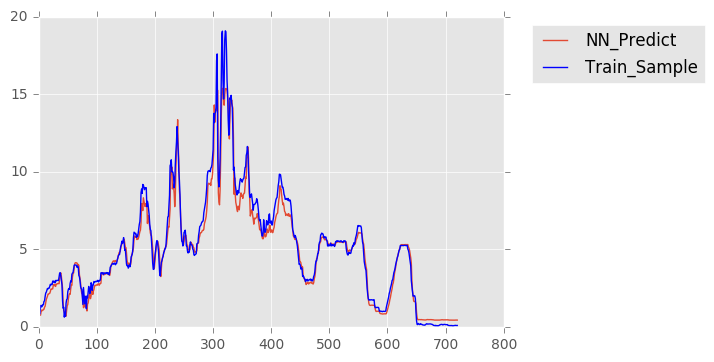

In [117]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

In [118]:
nn_forecast = nn_predict_series(nn, train_nn.iloc[-1:, 1:], len(test))

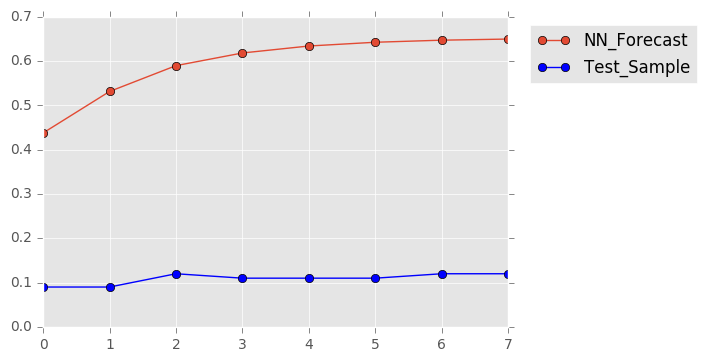

In [119]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.03, 1))

In [120]:
errors_out_sample(test, nn_forecast)

{'MAE': 0.48527491152286528, 'MSE': 0.23912817096244565}

### Hybrid

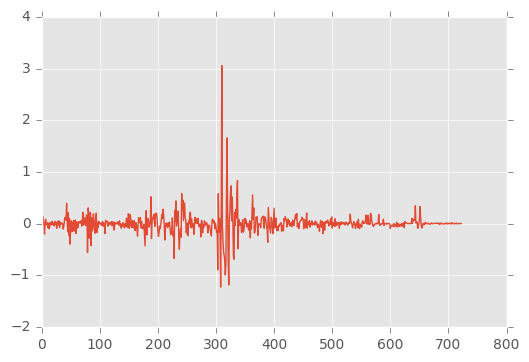

In [62]:
resids_arima = get_resids_arima(train, model)
plt.plot(resids_arima)
plt.show()

In [86]:
lags_nn = 4

df_nn_resid = create_df_for_nn_residuals(resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [87]:
nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.0636
Epoch 2/100
0s - loss: 0.0454
Epoch 3/100
0s - loss: 0.0453
Epoch 4/100
0s - loss: 0.0445
Epoch 5/100
0s - loss: 0.0445
Epoch 6/100
0s - loss: 0.0436
Epoch 7/100
0s - loss: 0.0435
Epoch 8/100
0s - loss: 0.0433
Epoch 9/100
0s - loss: 0.0428
Epoch 10/100
0s - loss: 0.0429
Epoch 11/100
0s - loss: 0.0424
Epoch 12/100
0s - loss: 0.0426
Epoch 13/100
0s - loss: 0.0424
Epoch 14/100
0s - loss: 0.0427
Epoch 15/100
0s - loss: 0.0432
Epoch 16/100
0s - loss: 0.0425
Epoch 17/100
0s - loss: 0.0424
Epoch 18/100
0s - loss: 0.0426
Epoch 19/100
0s - loss: 0.0419
Epoch 20/100
0s - loss: 0.0429
Epoch 21/100
0s - loss: 0.0423
Epoch 22/100
0s - loss: 0.0422
Epoch 23/100
0s - loss: 0.0424
Epoch 24/100
0s - loss: 0.0423
Epoch 25/100
0s - loss: 0.0424
Epoch 26/100
0s - loss: 0.0420
Epoch 27/100
0s - loss: 0.0423
Epoch 28/100
0s - loss: 0.0423
Epoch 29/100
0s - loss: 0.0420
Epoch 30/100
0s - loss: 0.0421
Epoch 31/100
0s - loss: 0.0424
Epoch 32/100
0s - loss: 0.0419
Epoch 33/100
0s -

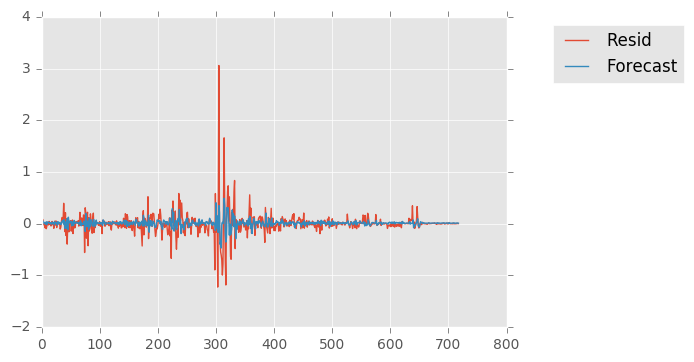

In [88]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.4,1), loc='best')
plt.show()

In [89]:
nn_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

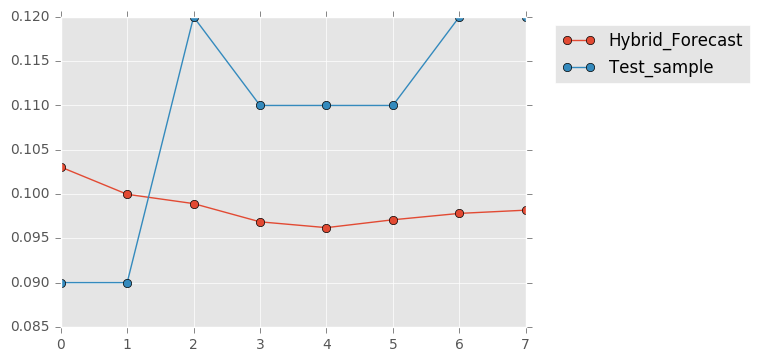

In [103]:
hybrid_plot_forecast(forc_arima, nn_resid_forecast, test)

In [99]:
hybrid_forecast = hybrid_predict_series(forc_arima, nn_resid_forecast)

In [102]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 0.015993612753533816, 'MSE': 0.00027650315728638974}

---

---

---

# RU Real GDP Pure

In [121]:
ru_gdp = df.iloc[11, 1:87].copy()
ru_gdp.index = pd.DatetimeIndex(start='1995-01', end='2016-07', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                 -0.775266
p-value                         0.826280
#Lags Used                      1.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


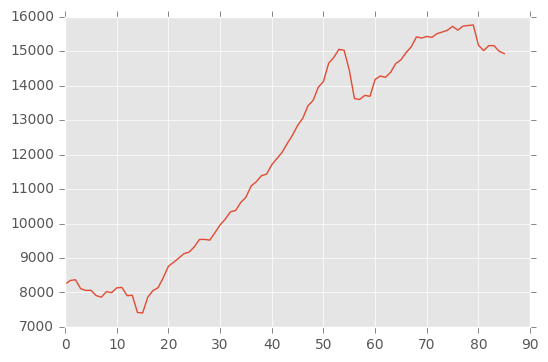

In [122]:
test_stationarity(ru_gdp)

Results of Dickey-Fuller Test:
Test Statistic                -5.828238e+00
p-value                        4.031817e-07
#Lags Used                     0.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (5%)           -2.896616e+00
Critical Value (1%)           -3.510712e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


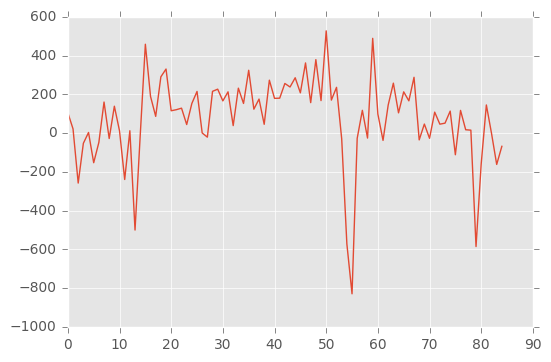

In [44]:
test_stationarity(diff_series(ru_gdp))

In [123]:
train = ru_gdp[:-5]
test = ru_gdp[-5:]

### ARIMA

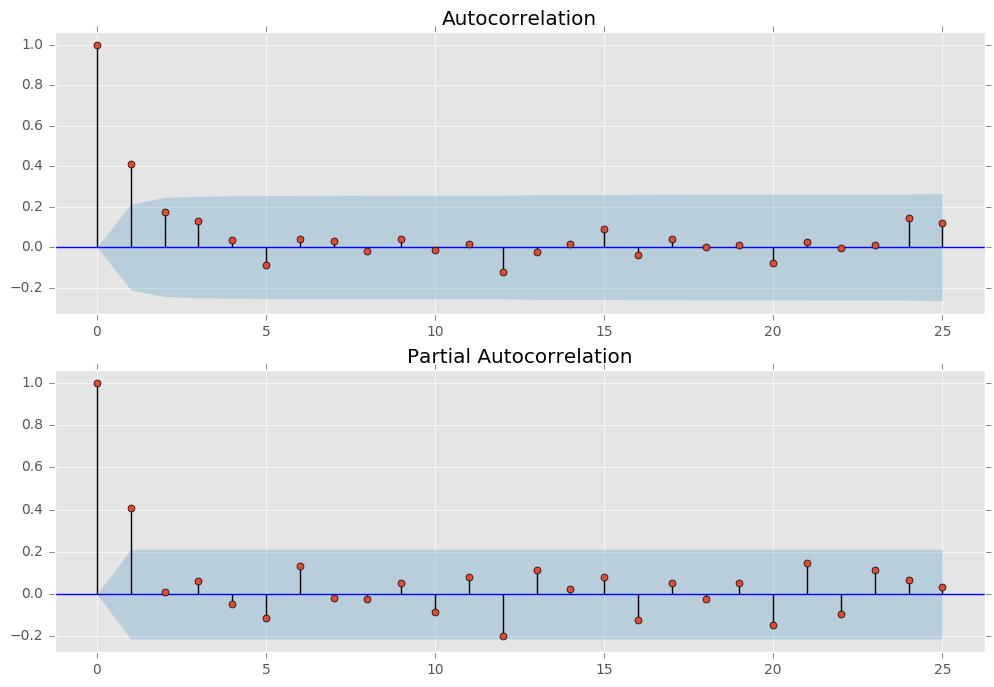

In [269]:
correlogram(diff_series(ru_gdp))

In [186]:
arima_model = ARIMA(np.array(train), order=(2,1,1)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   80
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -537.403
Method:                       css-mle   S.D. of innovations            198.375
Date:                Sun, 29 Jan 2017   AIC                           1084.806
Time:                        20:15:49   BIC                           1096.716
Sample:                             1   HQIC                          1089.581
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         94.5302     22.229      4.252      0.000        50.961   138.099
ar.L1.D.y      1.3967      0.107     13.042      0.000         1.187     1.607
ar.L2.D.y     -0.4274      0.107     -3.983      0.0

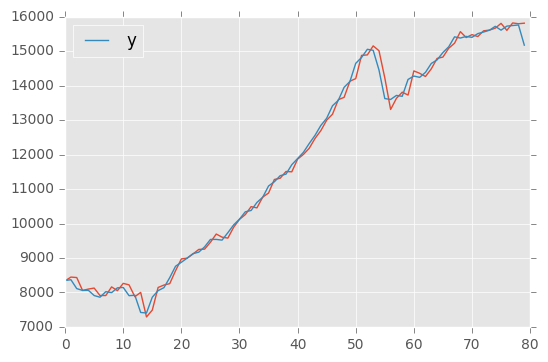

In [271]:
arima_model.plot_predict()
plt.show()

In [187]:
forc_arima = arima_model.forecast(len(test))

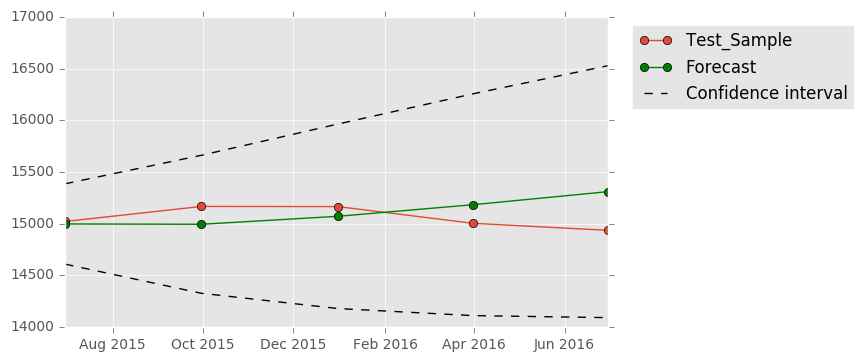

In [273]:
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

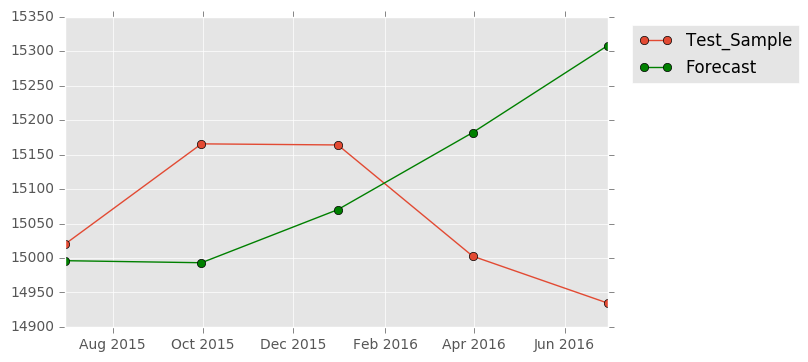

In [323]:
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1), conf_int=False)

In [151]:
errors_out_sample(test, forc_arima[0])

{'MAE': 168.75393384120179, 'MSE': 42210.533593500659}

### ANN

In [124]:
mean = train.mean()
z = train.max() - train.min()
scaled_train = train.copy()

In [125]:
scaled_train = (scaled_train-mean)/z

In [126]:
lags_for_nn = 2

In [127]:
train_nn = create_df_for_nn(scaled_train, lags_for_nn)

In [182]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [183]:
nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=150, 
       verbose=2,
       batch_size=1)

Epoch 1/150
0s - loss: 0.5651
Epoch 2/150
0s - loss: 0.1478
Epoch 3/150
0s - loss: 0.1186
Epoch 4/150
0s - loss: 0.1163
Epoch 5/150
0s - loss: 0.1130
Epoch 6/150
0s - loss: 0.1117
Epoch 7/150
0s - loss: 0.1062
Epoch 8/150
0s - loss: 0.1016
Epoch 9/150
0s - loss: 0.0958
Epoch 10/150
0s - loss: 0.0902
Epoch 11/150
0s - loss: 0.0826
Epoch 12/150
0s - loss: 0.0728
Epoch 13/150
0s - loss: 0.0611
Epoch 14/150
0s - loss: 0.0499
Epoch 15/150
0s - loss: 0.0365
Epoch 16/150
0s - loss: 0.0250
Epoch 17/150
0s - loss: 0.0156
Epoch 18/150
0s - loss: 0.0089
Epoch 19/150
0s - loss: 0.0048
Epoch 20/150
0s - loss: 0.0030
Epoch 21/150
0s - loss: 0.0022
Epoch 22/150
0s - loss: 0.0018
Epoch 23/150
0s - loss: 0.0017
Epoch 24/150
0s - loss: 0.0016
Epoch 25/150
0s - loss: 0.0016
Epoch 26/150
0s - loss: 0.0016
Epoch 27/150
0s - loss: 0.0016
Epoch 28/150
0s - loss: 0.0016
Epoch 29/150
0s - loss: 0.0015
Epoch 30/150
0s - loss: 0.0016
Epoch 31/150
0s - loss: 0.0016
Epoch 32/150
0s - loss: 0.0015
Epoch 33/150
0s -

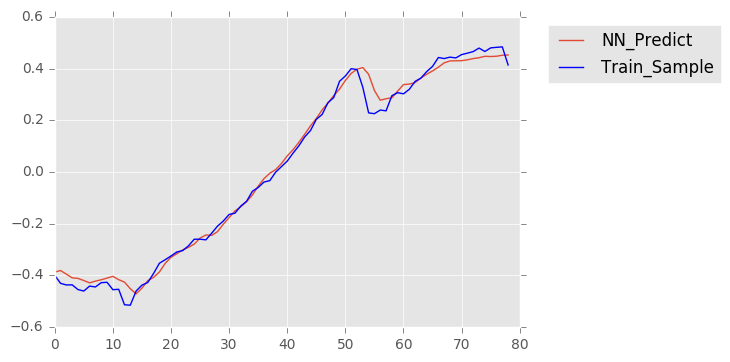

In [184]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

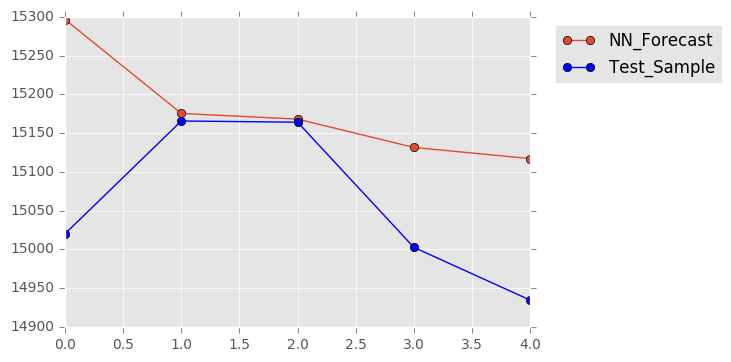

In [176]:
nn_forecast = np.array(nn_predict_series(nn, pd.DataFrame(train_nn.iloc[78, 1:]).T, len(test)))*z + mean
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

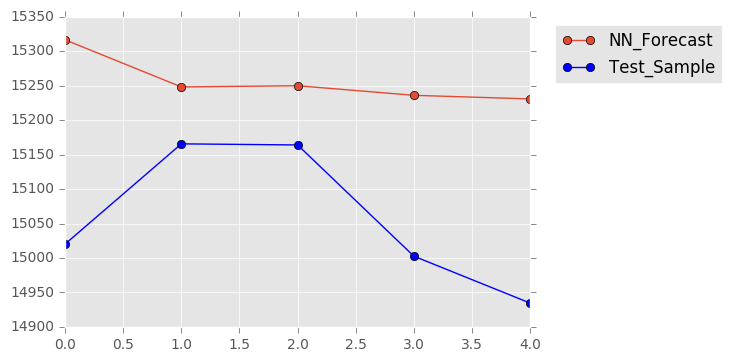

In [179]:
nn_forecast = np.array(nn_predict_series(nn, pd.DataFrame(train_nn.iloc[78, 1:]).T, len(test)))*z + mean
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

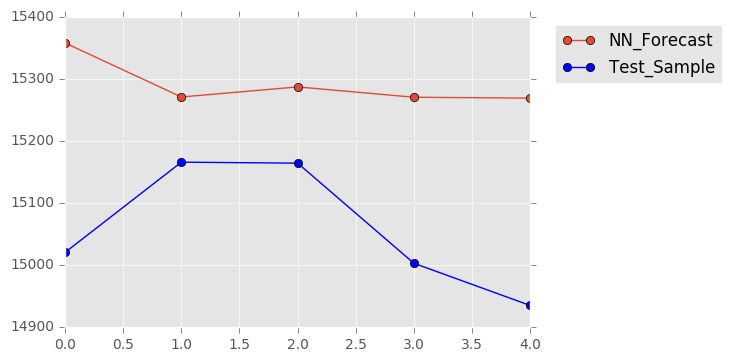

In [181]:
nn_forecast = np.array(nn_predict_series(nn, pd.DataFrame(train_nn.iloc[78, 1:]).T, len(test)))*z + mean
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

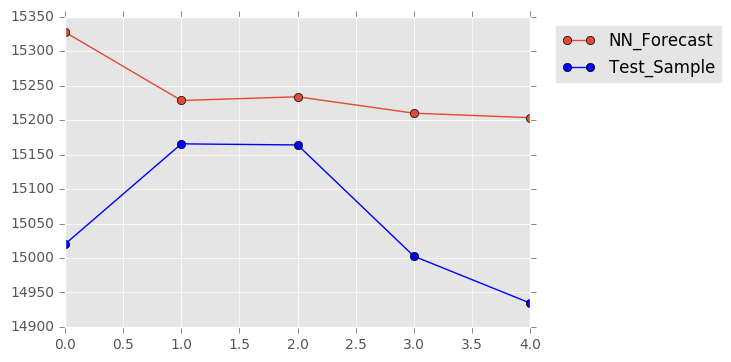

In [185]:
nn_forecast = np.array(nn_predict_series(nn, pd.DataFrame(train_nn.iloc[78, 1:]).T, len(test)))*z + mean
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

#### WIth Dropout

In [155]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [161]:
nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=150, 
       verbose=2,
       batch_size=1)

Epoch 1/150
1s - loss: 0.1949
Epoch 2/150
0s - loss: 0.1382
Epoch 3/150
0s - loss: 0.1345
Epoch 4/150
0s - loss: 0.1307
Epoch 5/150
0s - loss: 0.1233
Epoch 6/150
0s - loss: 0.1209
Epoch 7/150
0s - loss: 0.1227
Epoch 8/150
0s - loss: 0.1279
Epoch 9/150
0s - loss: 0.1343
Epoch 10/150
0s - loss: 0.1234
Epoch 11/150
0s - loss: 0.1244
Epoch 12/150
0s - loss: 0.1252
Epoch 13/150
0s - loss: 0.1270
Epoch 14/150
0s - loss: 0.1252
Epoch 15/150
0s - loss: 0.1162
Epoch 16/150
0s - loss: 0.1209
Epoch 17/150
0s - loss: 0.1211
Epoch 18/150
0s - loss: 0.1187
Epoch 19/150
0s - loss: 0.1088
Epoch 20/150
0s - loss: 0.1162
Epoch 21/150
0s - loss: 0.1079
Epoch 22/150
0s - loss: 0.1145
Epoch 23/150
0s - loss: 0.1130
Epoch 24/150
0s - loss: 0.1087
Epoch 25/150
0s - loss: 0.1047
Epoch 26/150
0s - loss: 0.1066
Epoch 27/150
0s - loss: 0.1010
Epoch 28/150
0s - loss: 0.1094
Epoch 29/150
0s - loss: 0.1092
Epoch 30/150
0s - loss: 0.0832
Epoch 31/150
0s - loss: 0.0813
Epoch 32/150
0s - loss: 0.1031
Epoch 33/150
0s -

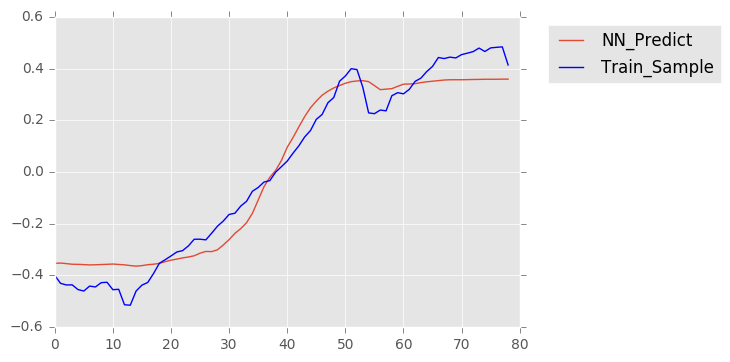

In [162]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

In [163]:
nn_forecast = np.array(nn_predict_series(nn, pd.DataFrame(train_nn.iloc[78, 1:]).T, len(test)))*z + mean

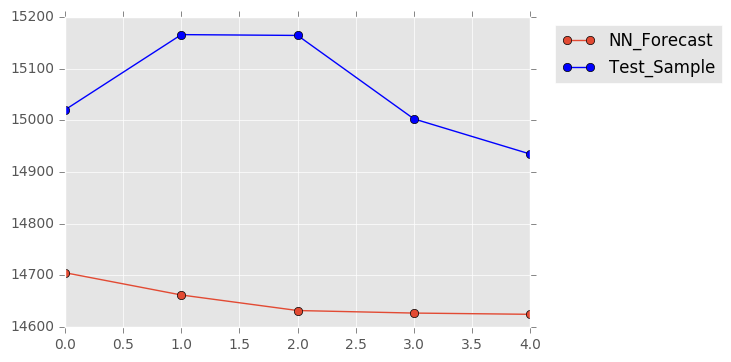

In [164]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [165]:
errors_out_sample(test, nn_forecast)

{'MAE': 407.58769099204, 'MSE': 174899.33374893724}

### Hybrid

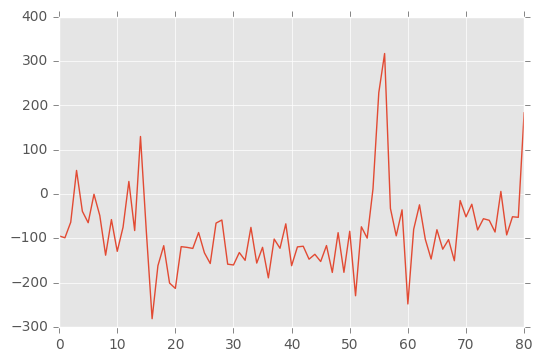

In [188]:
resids_arima = get_resids_arima(train, arima_model)
plt.plot(resids_arima)
plt.show()

In [189]:
scaled_resids_arima = scaler(resids_arima)[0]

In [214]:
lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [223]:
nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.0280
Epoch 2/100
0s - loss: 0.0264
Epoch 3/100
0s - loss: 0.0260
Epoch 4/100
0s - loss: 0.0255
Epoch 5/100
0s - loss: 0.0261
Epoch 6/100
0s - loss: 0.0262
Epoch 7/100
0s - loss: 0.0256
Epoch 8/100
0s - loss: 0.0259
Epoch 9/100
0s - loss: 0.0266
Epoch 10/100
0s - loss: 0.0253
Epoch 11/100
0s - loss: 0.0252
Epoch 12/100
0s - loss: 0.0251
Epoch 13/100
0s - loss: 0.0261
Epoch 14/100
0s - loss: 0.0248
Epoch 15/100
0s - loss: 0.0259
Epoch 16/100
0s - loss: 0.0258
Epoch 17/100
0s - loss: 0.0255
Epoch 18/100
0s - loss: 0.0255
Epoch 19/100
0s - loss: 0.0256
Epoch 20/100
0s - loss: 0.0247
Epoch 21/100
0s - loss: 0.0249
Epoch 22/100
0s - loss: 0.0249
Epoch 23/100
0s - loss: 0.0255
Epoch 24/100
0s - loss: 0.0264
Epoch 25/100
0s - loss: 0.0244
Epoch 26/100
0s - loss: 0.0258
Epoch 27/100
0s - loss: 0.0246
Epoch 28/100
0s - loss: 0.0242
Epoch 29/100
0s - loss: 0.0255
Epoch 30/100
0s - loss: 0.0253
Epoch 31/100
0s - loss: 0.0246
Epoch 32/100
0s - loss: 0.0248
Epoch 33/100
0s -

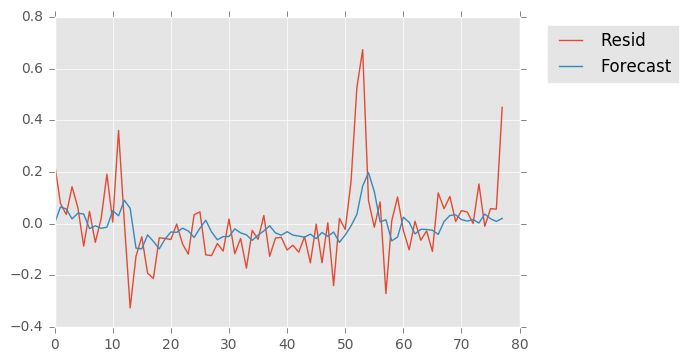

In [224]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [225]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

In [226]:
nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

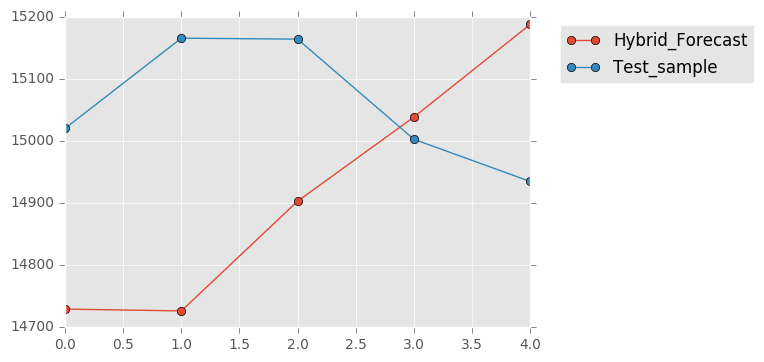

In [227]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [228]:
hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

In [229]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 256.34245618006901, 'MSE': 82439.702410844882}

In [230]:
nn_resids_forecast

array([-267.3795166 , -267.3795166 , -167.49099731, -143.73529053,
       -120.5721283 ], dtype=float32)

---

---

---

# RU Export Pure

In [3]:
ru_exp = df.iloc[13, 1:87].copy()
ru_exp.index = pd.DatetimeIndex(start='1995-01', end='2016-07', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                 -0.903524
p-value                         0.786810
#Lags Used                      2.000000
Number of Observations Used    83.000000
Critical Value (10%)           -2.585713
Critical Value (5%)            -2.897048
Critical Value (1%)            -3.511712
dtype: float64


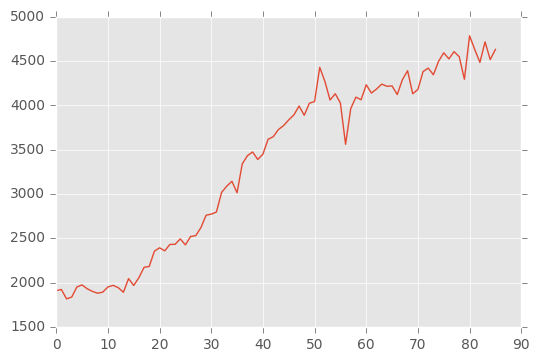

In [4]:
test_stationarity(ru_exp)

Results of Dickey-Fuller Test:
Test Statistic                -1.024904e+01
p-value                        4.536603e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.300000e+01
Critical Value (10%)          -2.585713e+00
Critical Value (5%)           -2.897048e+00
Critical Value (1%)           -3.511712e+00
dtype: float64


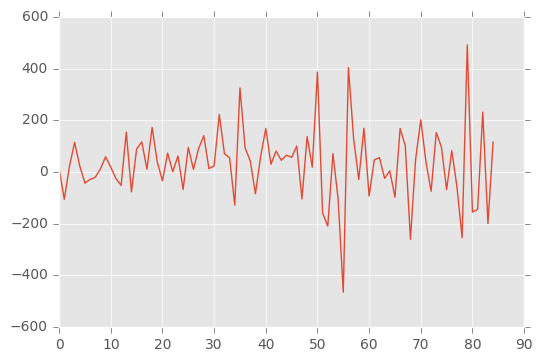

In [5]:
test_stationarity(diff_series(ru_exp))

In [6]:
train = ru_exp[:-5]
test = ru_exp[-5:]

### ARIMA

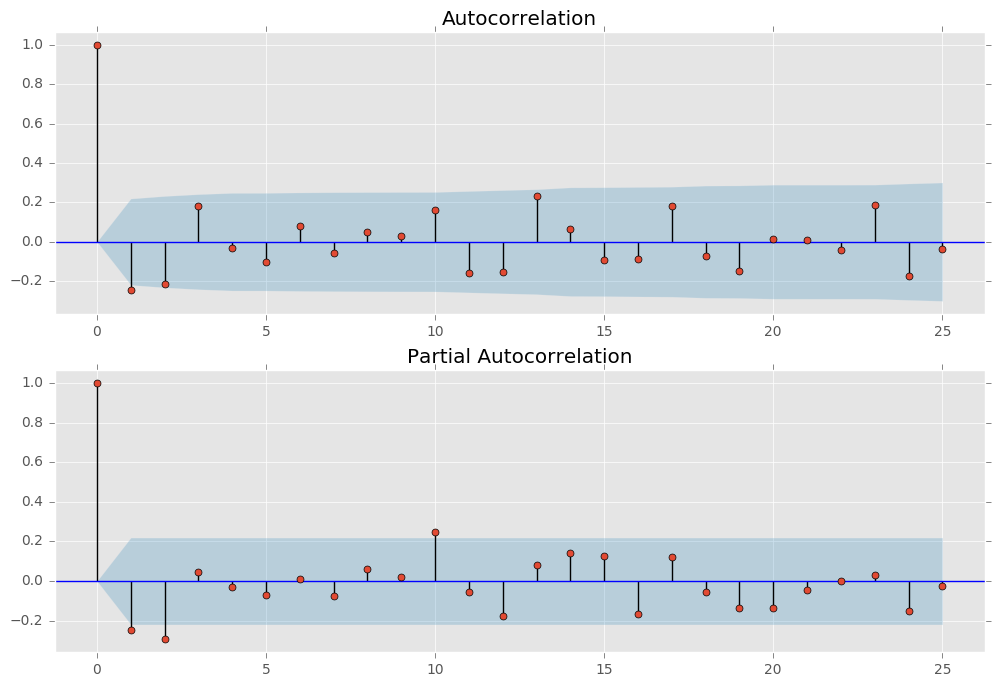

In [9]:
correlogram(diff_series(train))

In [10]:
arima_model = ARIMA(np.array(train), order=(0,1,1)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   80
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -503.471
Method:                       css-mle   S.D. of innovations            130.751
Date:                Fri, 27 Jan 2017   AIC                           1012.942
Time:                        19:34:13   BIC                           1020.088
Sample:                             1   HQIC                          1015.807
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         34.7102      8.691      3.994      0.000        17.677    51.743
ma.L1.D.y     -0.4107      0.108     -3.817      0.000        -0.622    -0.200
                                    Roots           

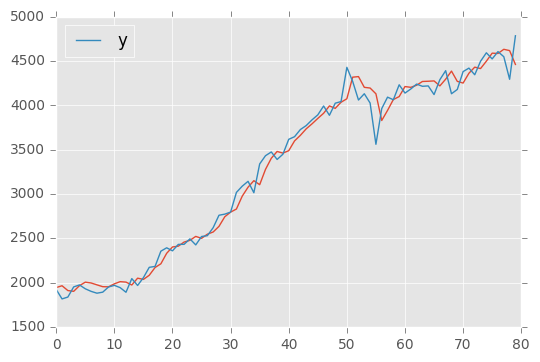

In [11]:
arima_model.plot_predict()
plt.show()

In [12]:
forc_arima = arima_model.forecast(len(test))

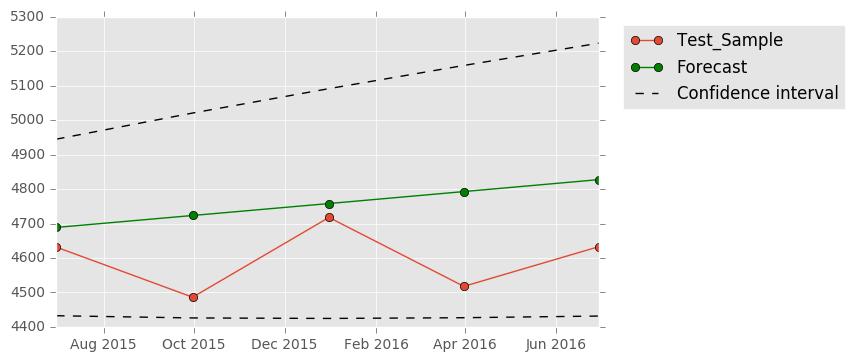

In [13]:
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [14]:
errors_out_sample(test, forc_arima[0])

{'MAE': 160.88196097464532, 'MSE': 34949.892155337126}

### ANN

In [7]:
scaled_train = scaler(train)[0]

In [8]:
lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

In [20]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [38]:
nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.1221
Epoch 2/100
0s - loss: 0.0845
Epoch 3/100
0s - loss: 0.0741
Epoch 4/100
0s - loss: 0.0640
Epoch 5/100
0s - loss: 0.0546
Epoch 6/100
0s - loss: 0.0488
Epoch 7/100
0s - loss: 0.0376
Epoch 8/100
0s - loss: 0.0287
Epoch 9/100
0s - loss: 0.0222
Epoch 10/100
0s - loss: 0.0157
Epoch 11/100
0s - loss: 0.0108
Epoch 12/100
0s - loss: 0.0074
Epoch 13/100
0s - loss: 0.0054
Epoch 14/100
0s - loss: 0.0038
Epoch 15/100
0s - loss: 0.0030
Epoch 16/100
0s - loss: 0.0025
Epoch 17/100
0s - loss: 0.0024
Epoch 18/100
0s - loss: 0.0023
Epoch 19/100
0s - loss: 0.0023
Epoch 20/100
0s - loss: 0.0022
Epoch 21/100
0s - loss: 0.0022
Epoch 22/100
0s - loss: 0.0022
Epoch 23/100
0s - loss: 0.0023
Epoch 24/100
0s - loss: 0.0024
Epoch 25/100
0s - loss: 0.0022
Epoch 26/100
0s - loss: 0.0022
Epoch 27/100
0s - loss: 0.0021
Epoch 28/100
0s - loss: 0.0023
Epoch 29/100
0s - loss: 0.0023
Epoch 30/100
0s - loss: 0.0022
Epoch 31/100
0s - loss: 0.0023
Epoch 32/100
0s - loss: 0.0023
Epoch 33/100
0s -

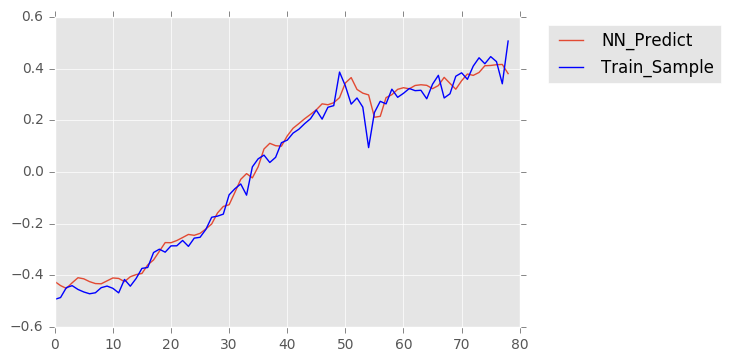

In [26]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

In [39]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

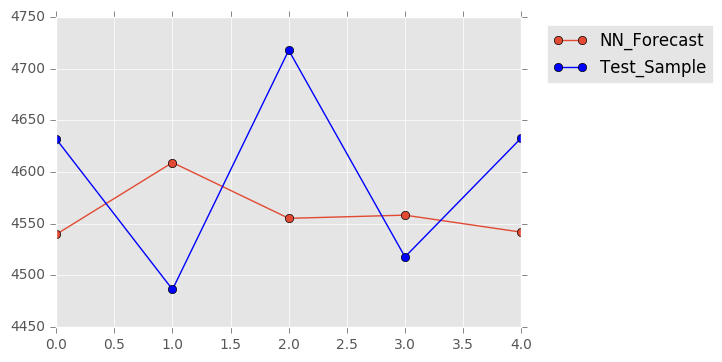

In [40]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

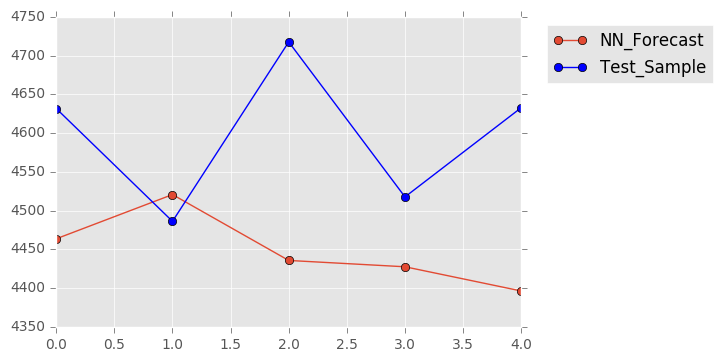

In [37]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

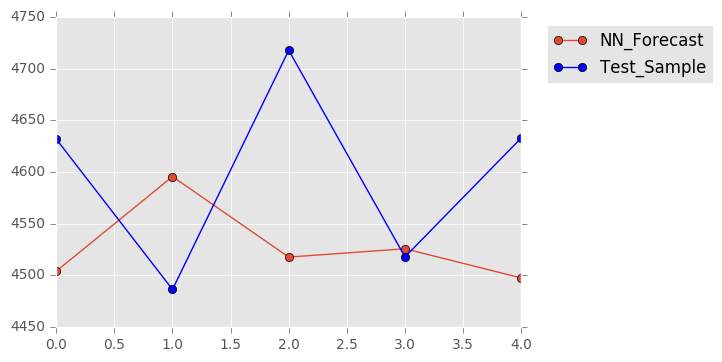

In [34]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

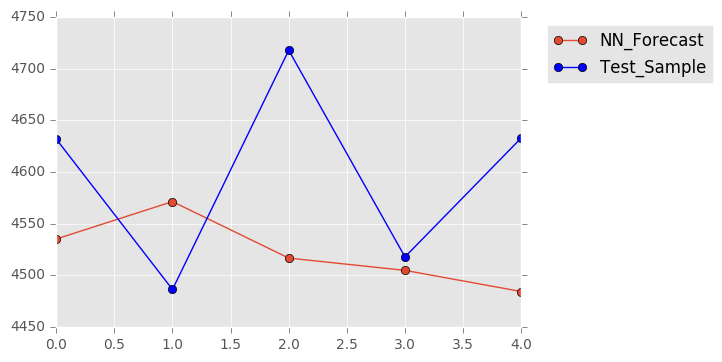

In [31]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

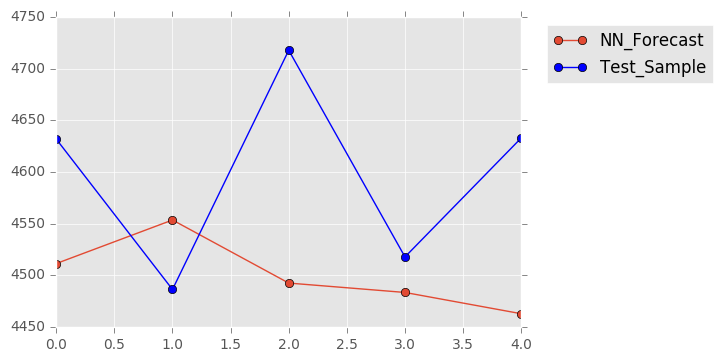

In [28]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

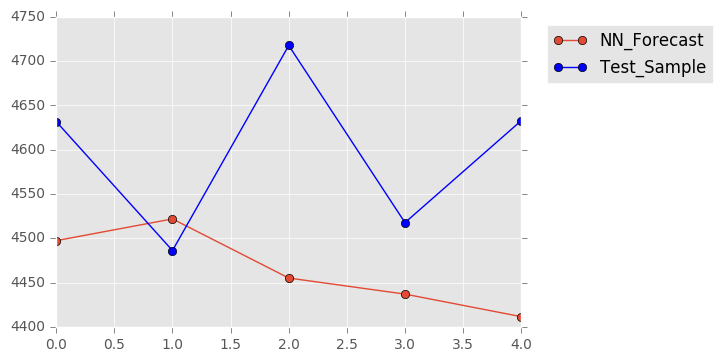

In [24]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [19]:
errors_out_sample(test, nn_forecast)

{'MAE': 107.81270831834991, 'MSE': 14120.014541740447}

### Hybrid

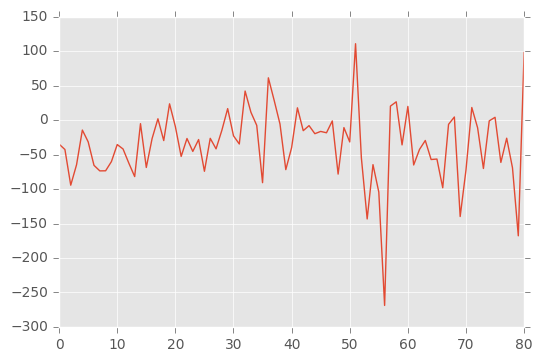

In [75]:
resids_arima = get_resids_arima(train, arima_model)
plt.plot(resids_arima)
plt.show()

In [76]:
scaled_resids_arima = scaler(resids_arima)[0]

In [89]:
lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

In [90]:
nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.4698
Epoch 2/100
0s - loss: 0.0472
Epoch 3/100
0s - loss: 0.0211
Epoch 4/100
0s - loss: 0.0207
Epoch 5/100
0s - loss: 0.0208
Epoch 6/100
0s - loss: 0.0206
Epoch 7/100
0s - loss: 0.0207
Epoch 8/100
0s - loss: 0.0208
Epoch 9/100
0s - loss: 0.0207
Epoch 10/100
0s - loss: 0.0207
Epoch 11/100
0s - loss: 0.0204
Epoch 12/100
0s - loss: 0.0206
Epoch 13/100
0s - loss: 0.0204
Epoch 14/100
0s - loss: 0.0205
Epoch 15/100
0s - loss: 0.0209
Epoch 16/100
0s - loss: 0.0207
Epoch 17/100
0s - loss: 0.0212
Epoch 18/100
0s - loss: 0.0204
Epoch 19/100
0s - loss: 0.0204
Epoch 20/100
0s - loss: 0.0211
Epoch 21/100
0s - loss: 0.0207
Epoch 22/100
0s - loss: 0.0210
Epoch 23/100
0s - loss: 0.0206
Epoch 24/100
0s - loss: 0.0212
Epoch 25/100
0s - loss: 0.0219
Epoch 26/100
0s - loss: 0.0205
Epoch 27/100
0s - loss: 0.0202
Epoch 28/100
0s - loss: 0.0211
Epoch 29/100
0s - loss: 0.0208
Epoch 30/100
0s - loss: 0.0213
Epoch 31/100
0s - loss: 0.0210
Epoch 32/100
0s - loss: 0.0222
Epoch 33/100
0s -

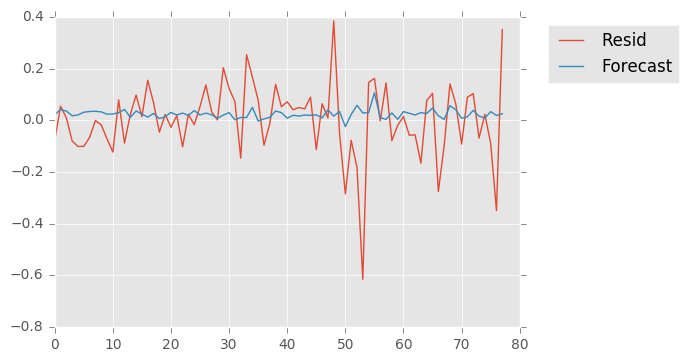

In [91]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [92]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

In [94]:
nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

In [96]:
hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

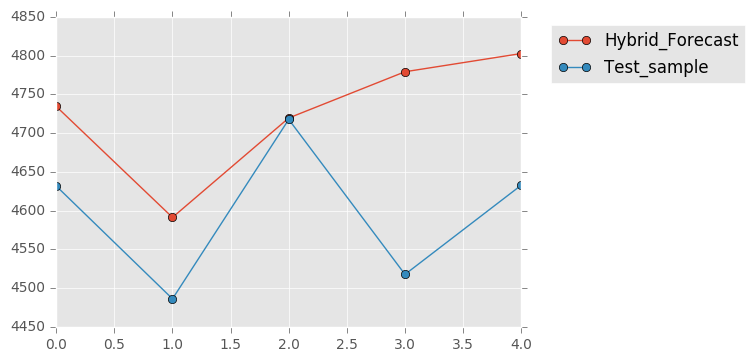

In [98]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [99]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 128.19737845511409, 'MSE': 23766.593473263707}

---

---

---

# Government consumption expenditures and gross investment

In [41]:
gov_consump_inv = df.iloc[32, 1:186].copy()
gov_consump_inv.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   0.619421
p-value                          0.988085
#Lags Used                      14.000000
Number of Observations Used    170.000000
Critical Value (10%)            -2.575917
Critical Value (5%)             -2.878696
Critical Value (1%)             -3.469413
dtype: float64


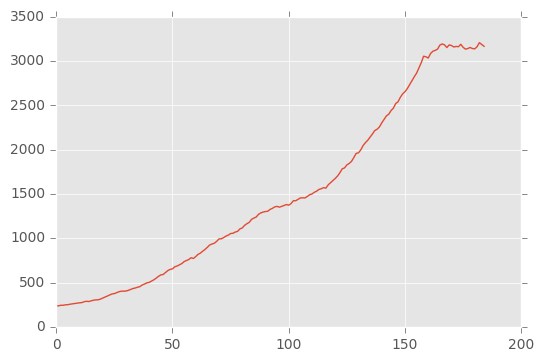

In [5]:
test_stationarity(gov_consump_inv)

Results of Dickey-Fuller Test:
Test Statistic                  -2.785001
p-value                          0.060448
#Lags Used                      13.000000
Number of Observations Used    170.000000
Critical Value (10%)            -2.575917
Critical Value (5%)             -2.878696
Critical Value (1%)             -3.469413
dtype: float64


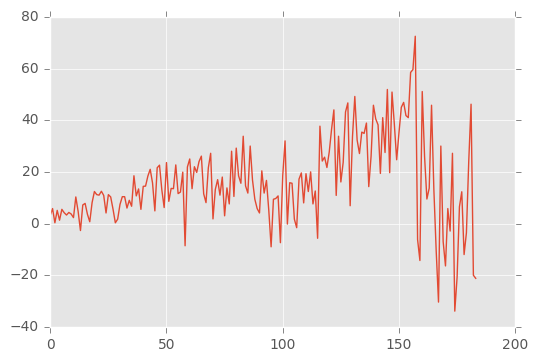

In [6]:
test_stationarity(diff_series(gov_consump_inv))

Results of Dickey-Fuller Test:
Test Statistic                -8.139737e+00
p-value                        1.035898e-12
#Lags Used                     6.000000e+00
Number of Observations Used    1.760000e+02
Critical Value (10%)          -2.575602e+00
Critical Value (5%)           -2.878106e+00
Critical Value (1%)           -3.468062e+00
dtype: float64


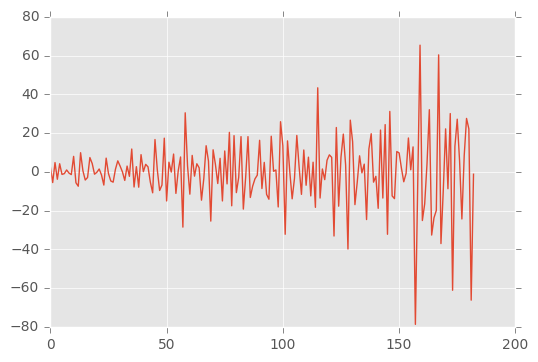

In [7]:
test_stationarity(diff_series(diff_series(gov_consump_inv)))

In [42]:
train = gov_consump_inv[:-9]
test = gov_consump_inv[-9:]

### ARIMA

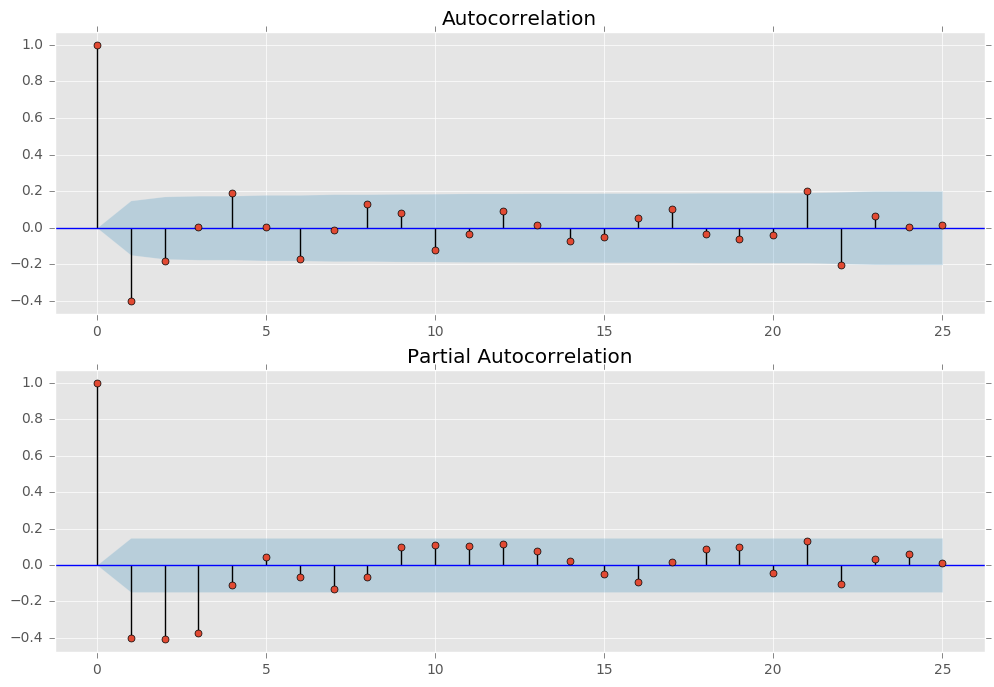

In [9]:
correlogram(diff_series(diff_series(train)))

In [43]:
arima_model = ARIMA(np.array(train), order=(1,2,3)).fit(trend='nc')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  174
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -692.866
Method:                       css-mle   S.D. of innovations             12.926
Date:                Mon, 30 Jan 2017   AIC                           1395.732
Time:                        21:34:30   BIC                           1411.527
Sample:                             2   HQIC                          1402.139
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D2.y     0.3140      0.255      1.233      0.219        -0.185     0.813
ma.L1.D2.y    -1.1741      0.248     -4.739      0.000        -1.660    -0.689
ma.L2.D2.y     0.1662      0.250      0.664      0.5

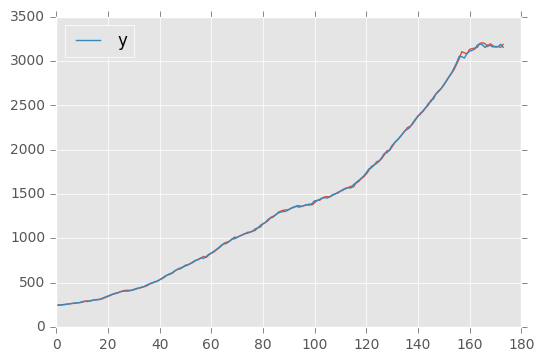

In [11]:
arima_model.plot_predict()
plt.show()

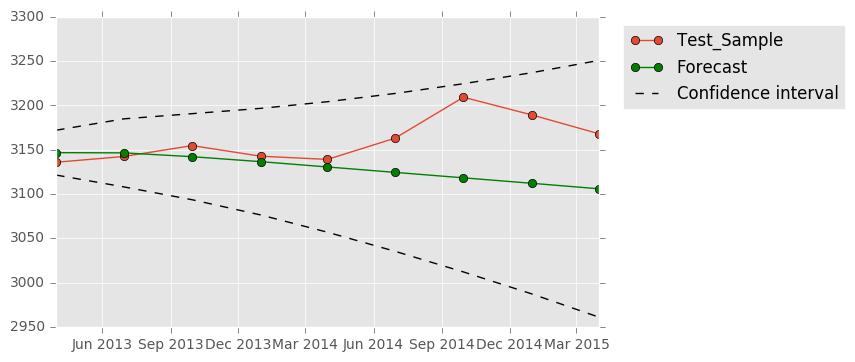

In [44]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [45]:
errors_out_sample(test, forc_arima[0])

{'MAE': 34.57317306467894, 'MSE': 2222.3748767294387}

### ANN

#### First launch

In [46]:
scaled_train = scaler(train)[0]

In [47]:
lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

In [48]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    #model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.2688
Epoch 2/100
0s - loss: 0.0697
Epoch 3/100
0s - loss: 0.0546
Epoch 4/100
0s - loss: 0.0400
Epoch 5/100
0s - loss: 0.0273
Epoch 6/100
0s - loss: 0.0168
Epoch 7/100
0s - loss: 0.0091
Epoch 8/100
0s - loss: 0.0041
Epoch 9/100
0s - loss: 0.0017
Epoch 10/100
0s - loss: 6.4248e-04
Epoch 11/100
0s - loss: 2.8630e-04
Epoch 12/100
0s - loss: 2.0236e-04
Epoch 13/100
0s - loss: 1.8040e-04
Epoch 14/100
0s - loss: 1.7268e-04
Epoch 15/100
0s - loss: 1.6958e-04
Epoch 16/100
0s - loss: 1.7558e-04
Epoch 17/100
0s - loss: 1.6919e-04
Epoch 18/100
0s - loss: 1.6335e-04
Epoch 19/100
0s - loss: 1.6453e-04
Epoch 20/100
0s - loss: 1.6061e-04
Epoch 21/100
0s - loss: 1.5024e-04
Epoch 22/100
0s - loss: 1.5564e-04
Epoch 23/100
0s - loss: 1.4564e-04
Epoch 24/100
0s - loss: 1.4319e-04
Epoch 25/100
0s - loss: 1.4152e-04
Epoch 26/100
0s - loss: 1.4688e-04
Epoch 27/100
0s - loss: 1.3935e-04
Epoch 28/100
0s - loss: 1.3438e-04
Epoch 29/100
0s - loss: 1.3045e-04
Epoch 30/100
0s - loss: 1.4259

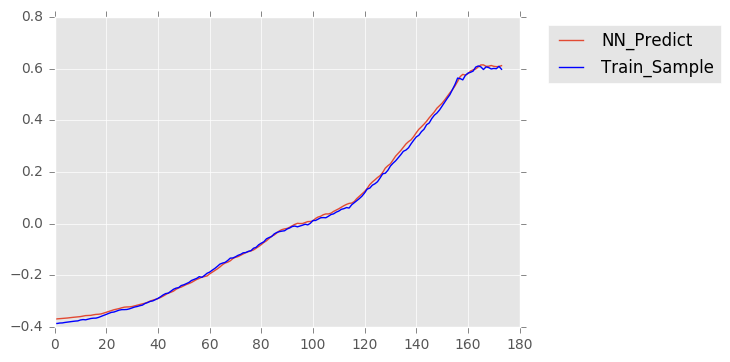

In [76]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

In [77]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

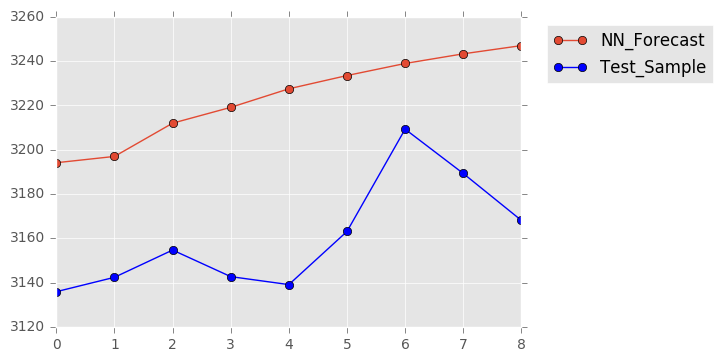

In [78]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [65]:
errors_out_sample(test, nn_forecast)

{'MAE': 26.241715494791759, 'MSE': 802.30014269855667}

#### Second launch

In [82]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    #model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

Epoch 1/100
0s - loss: 0.1004
Epoch 2/100
0s - loss: 0.0749
Epoch 3/100
0s - loss: 0.0601
Epoch 4/100
0s - loss: 0.0443
Epoch 5/100
0s - loss: 0.0248
Epoch 6/100
0s - loss: 0.0120
Epoch 7/100
0s - loss: 0.0040
Epoch 8/100
0s - loss: 0.0011
Epoch 9/100
0s - loss: 2.6319e-04
Epoch 10/100
0s - loss: 1.0701e-04
Epoch 11/100
0s - loss: 8.4920e-05
Epoch 12/100
0s - loss: 8.4080e-05
Epoch 13/100
0s - loss: 8.2996e-05
Epoch 14/100
0s - loss: 8.2104e-05
Epoch 15/100
0s - loss: 8.3267e-05
Epoch 16/100
0s - loss: 8.3786e-05
Epoch 17/100
0s - loss: 8.1336e-05
Epoch 18/100
0s - loss: 7.8263e-05
Epoch 19/100
0s - loss: 8.2767e-05
Epoch 20/100
0s - loss: 8.5012e-05
Epoch 21/100
0s - loss: 7.6149e-05
Epoch 22/100
0s - loss: 7.7639e-05
Epoch 23/100
0s - loss: 7.2787e-05
Epoch 24/100
0s - loss: 7.3226e-05
Epoch 25/100
0s - loss: 7.4316e-05
Epoch 26/100
0s - loss: 7.4557e-05
Epoch 27/100
0s - loss: 7.8349e-05
Epoch 28/100
0s - loss: 8.1261e-05
Epoch 29/100
0s - loss: 8.2692e-05
Epoch 30/100
0s - loss: 7.

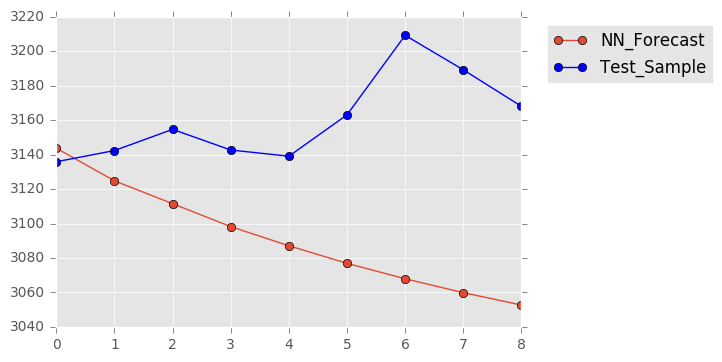

In [83]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [81]:
errors_out_sample(test, nn_forecast)

{'MAE': 75.679942491319451, 'MSE': 6027.7777862996572}

#### Third launch (anouther NN)

In [49]:
lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

In [50]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

Epoch 1/100
1s - loss: 1.1889
Epoch 2/100
0s - loss: 0.6937
Epoch 3/100
0s - loss: 0.4472
Epoch 4/100
0s - loss: 0.3811
Epoch 5/100
0s - loss: 0.3439
Epoch 6/100
0s - loss: 0.2542
Epoch 7/100
0s - loss: 0.2424
Epoch 8/100
0s - loss: 0.1972
Epoch 9/100
0s - loss: 0.1704
Epoch 10/100
0s - loss: 0.1389
Epoch 11/100
0s - loss: 0.1202
Epoch 12/100
0s - loss: 0.1147
Epoch 13/100
0s - loss: 0.1117
Epoch 14/100
0s - loss: 0.1174
Epoch 15/100
0s - loss: 0.1216
Epoch 16/100
0s - loss: 0.1189
Epoch 17/100
0s - loss: 0.1104
Epoch 18/100
0s - loss: 0.1031
Epoch 19/100
0s - loss: 0.1073
Epoch 20/100
0s - loss: 0.0986
Epoch 21/100
0s - loss: 0.1028
Epoch 22/100
0s - loss: 0.1036
Epoch 23/100
0s - loss: 0.1057
Epoch 24/100
0s - loss: 0.0961
Epoch 25/100
0s - loss: 0.0932
Epoch 26/100
0s - loss: 0.0993
Epoch 27/100
0s - loss: 0.0936
Epoch 28/100
0s - loss: 0.0919
Epoch 29/100
0s - loss: 0.0905
Epoch 30/100
0s - loss: 0.0920
Epoch 31/100
0s - loss: 0.0826
Epoch 32/100
0s - loss: 0.0723
Epoch 33/100
0s -

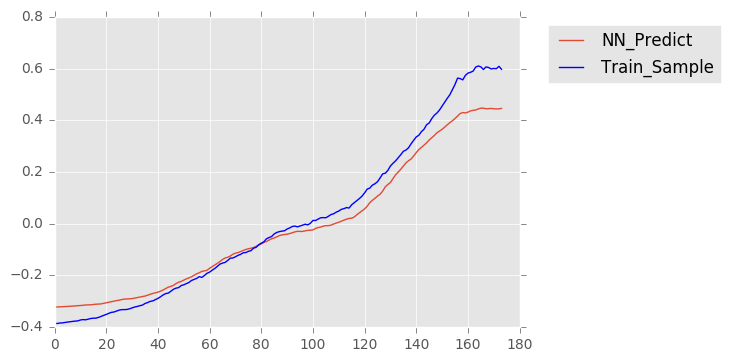

In [51]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

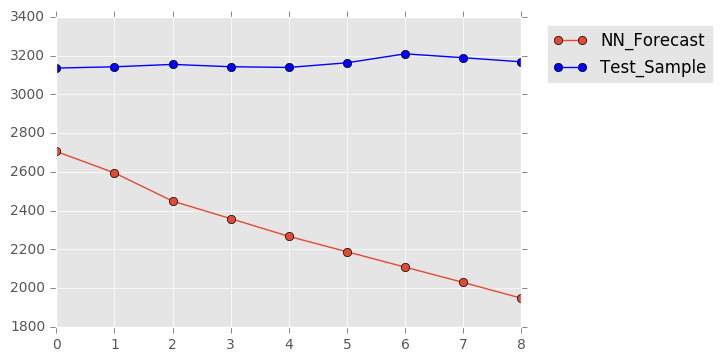

In [52]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [53]:
errors_out_sample(test, nn_forecast)

{'MAE': 866.17723524305563, 'MSE': 817202.33647942403}

### Hybrid

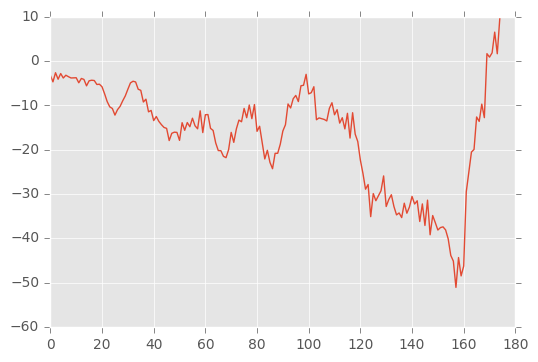

In [49]:
resids_arima = get_resids_arima(train, arima_model, d=2)
plt.plot(resids_arima)
plt.show()

In [132]:
scaled_resids_arima = scaler(resids_arima)[0]

In [165]:
lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.1438
Epoch 2/100
0s - loss: 0.0522
Epoch 3/100
0s - loss: 0.0511
Epoch 4/100
0s - loss: 0.0491
Epoch 5/100
0s - loss: 0.0420
Epoch 6/100
0s - loss: 0.0409
Epoch 7/100
0s - loss: 0.0449
Epoch 8/100
0s - loss: 0.0380
Epoch 9/100
0s - loss: 0.0392
Epoch 10/100
0s - loss: 0.0404
Epoch 11/100
0s - loss: 0.0423
Epoch 12/100
0s - loss: 0.0382
Epoch 13/100
0s - loss: 0.0387
Epoch 14/100
0s - loss: 0.0383
Epoch 15/100
0s - loss: 0.0392
Epoch 16/100
0s - loss: 0.0382
Epoch 17/100
0s - loss: 0.0404
Epoch 18/100
0s - loss: 0.0363
Epoch 19/100
0s - loss: 0.0395
Epoch 20/100
0s - loss: 0.0362
Epoch 21/100
0s - loss: 0.0344
Epoch 22/100
0s - loss: 0.0357
Epoch 23/100
0s - loss: 0.0328
Epoch 24/100
0s - loss: 0.0321
Epoch 25/100
0s - loss: 0.0278
Epoch 26/100
0s - loss: 0.0244
Epoch 27/100
0s - loss: 0.0261
Epoch 28/100
0s - loss: 0.0254
Epoch 29/100
0s - loss: 0.0192
Epoch 30/100
0s - loss: 0.0198
Epoch 31/100
0s - loss: 0.0173
Epoch 32/100
0s - loss: 0.0171
Epoch 33/100
0s -

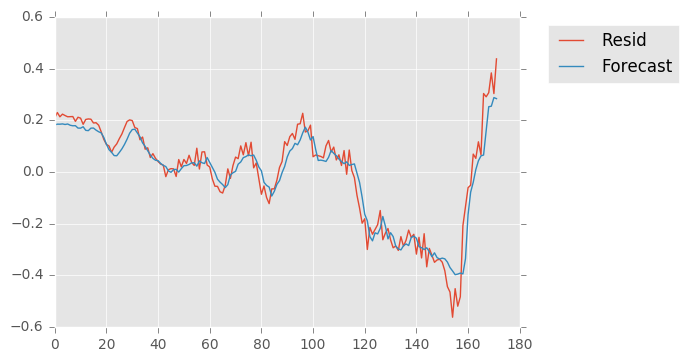

In [166]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [167]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

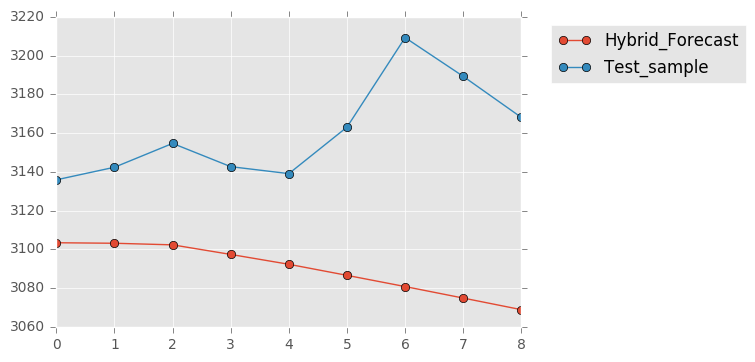

In [168]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [169]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 70.531292823046954, 'MSE': 6097.1594834085818}

---

---

---

# Real Government Consumption Expenditures and Gross Investment, Chained Dollars

In [231]:
real_gov_ci = df.iloc[40, 1:66].copy()
real_gov_ci.index = pd.DatetimeIndex(start='1999-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                 -2.775523
p-value                         0.061856
#Lags Used                      6.000000
Number of Observations Used    58.000000
Critical Value (10%)           -2.594129
Critical Value (5%)            -2.912837
Critical Value (1%)            -3.548494
dtype: float64


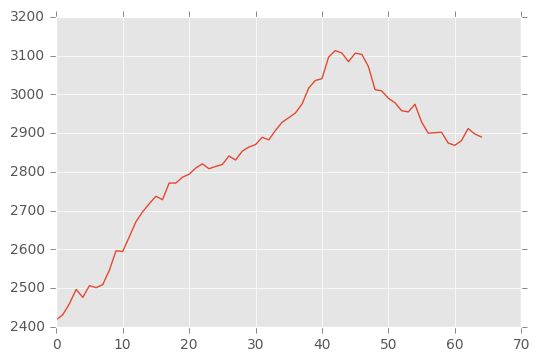

In [187]:
test_stationarity(real_gov_ci)

Results of Dickey-Fuller Test:
Test Statistic                 -1.787689
p-value                         0.386591
#Lags Used                      7.000000
Number of Observations Used    56.000000
Critical Value (10%)           -2.595137
Critical Value (5%)            -2.914731
Critical Value (1%)            -3.552928
dtype: float64


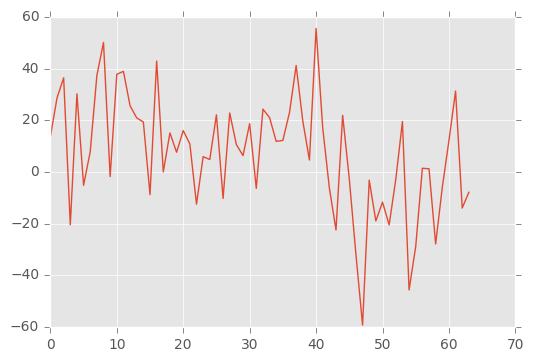

In [188]:
test_stationarity(diff_series(real_gov_ci))

Results of Dickey-Fuller Test:
Test Statistic                 -3.495373
p-value                         0.008107
#Lags Used                      6.000000
Number of Observations Used    56.000000
Critical Value (10%)           -2.595137
Critical Value (5%)            -2.914731
Critical Value (1%)            -3.552928
dtype: float64


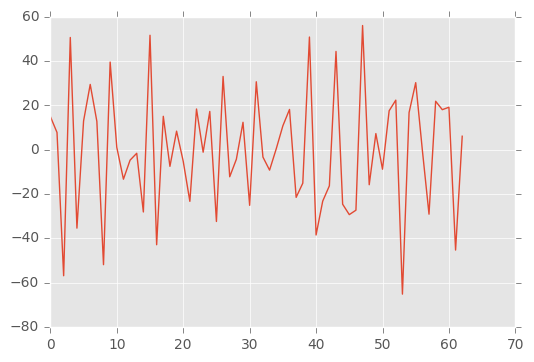

In [189]:
test_stationarity(diff_series(diff_series(real_gov_ci)))

In [232]:
train = real_gov_ci[:-4]
test = real_gov_ci[-4:]

### ARIMA

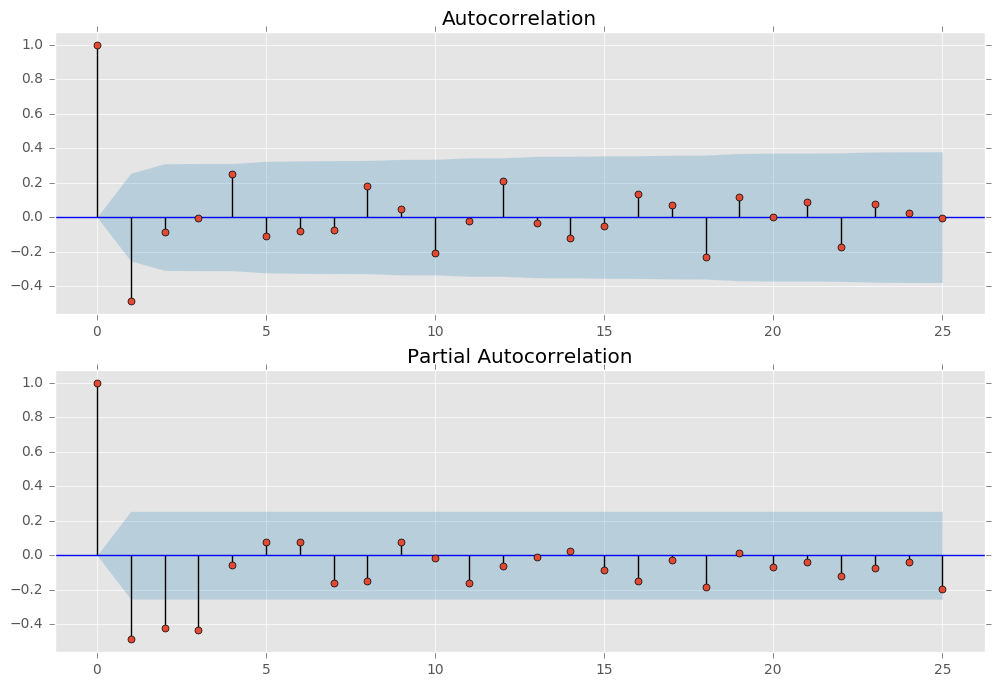

In [220]:
correlogram(diff_series(diff_series(train)))

In [233]:
arima_model = ARIMA(np.array(train), order=(1,2,2)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   59
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -261.937
Method:                       css-mle   S.D. of innovations             19.940
Date:                Sun, 29 Jan 2017   AIC                            533.873
Time:                        20:28:47   BIC                            544.261
Sample:                             2   HQIC                           537.928
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.6216      0.216     -2.883      0.006        -1.044    -0.199
ar.L1.D2.y     0.8128      0.190      4.284      0.000         0.441     1.185
ma.L1.D2.y    -1.7023      0.208     -8.181      0.0

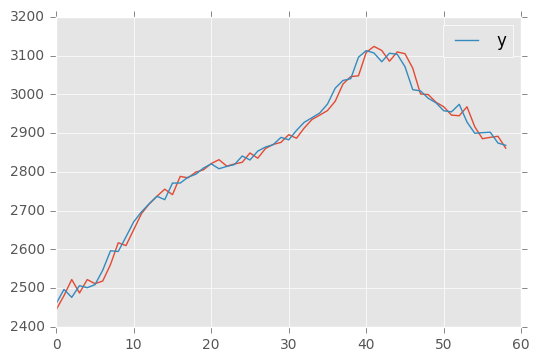

In [222]:
arima_model.plot_predict()
plt.show()

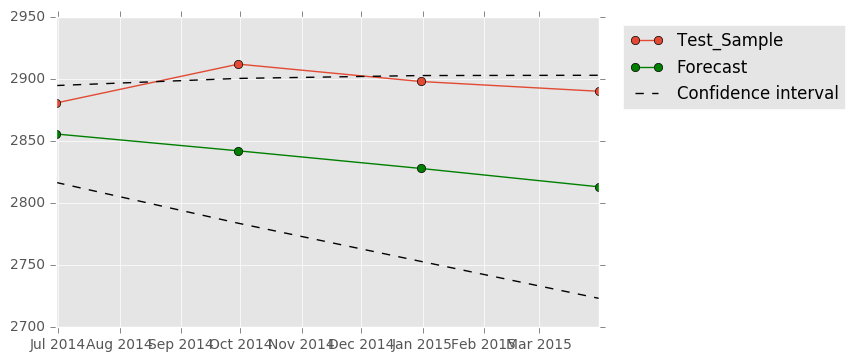

In [234]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [224]:
errors_out_sample(test, forc_arima[0])

{'MAE': 60.525630143327476, 'MSE': 4091.0758422665949}

### ANN

In [225]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

In [279]:
def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.1446
Epoch 2/100
0s - loss: 0.0767
Epoch 3/100
0s - loss: 0.0994
Epoch 4/100
0s - loss: 0.0779
Epoch 5/100
0s - loss: 0.0759
Epoch 6/100
0s - loss: 0.0785
Epoch 7/100
0s - loss: 0.0597
Epoch 8/100
0s - loss: 0.0771
Epoch 9/100
0s - loss: 0.0714
Epoch 10/100
0s - loss: 0.0879
Epoch 11/100
0s - loss: 0.0660
Epoch 12/100
0s - loss: 0.0824
Epoch 13/100
0s - loss: 0.0699
Epoch 14/100
0s - loss: 0.0703
Epoch 15/100
0s - loss: 0.0742
Epoch 16/100
0s - loss: 0.0690
Epoch 17/100
0s - loss: 0.0676
Epoch 18/100
0s - loss: 0.0743
Epoch 19/100
0s - loss: 0.0675
Epoch 20/100
0s - loss: 0.0656
Epoch 21/100
0s - loss: 0.0656
Epoch 22/100
0s - loss: 0.0705
Epoch 23/100
0s - loss: 0.0680
Epoch 24/100
0s - loss: 0.0681
Epoch 25/100
0s - loss: 0.0676
Epoch 26/100
0s - loss: 0.0704
Epoch 27/100
0s - loss: 0.0712
Epoch 28/100
0s - loss: 0.0664
Epoch 29/100
0s - loss: 0.0689
Epoch 30/100
0s - loss: 0.0639
Epoch 31/100
0s - loss: 0.0675
Epoch 32/100
0s - loss: 0.0670
Epoch 33/100
0s -

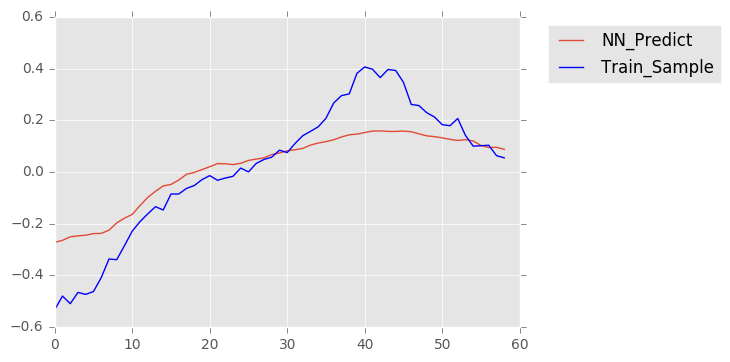

In [280]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

In [281]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

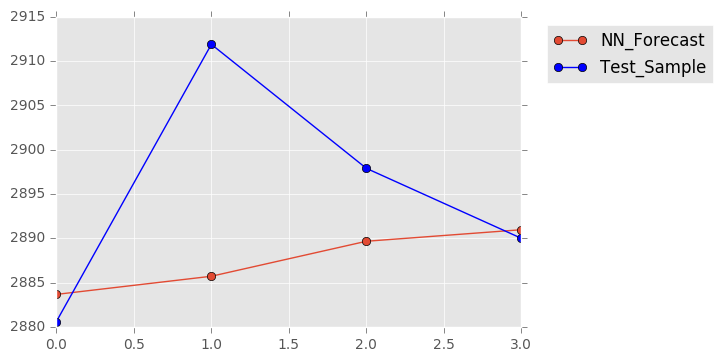

In [282]:
nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [283]:
errors_out_sample(test, nn_forecast)

{'MAE': 9.6134765625000682, 'MSE': 190.91476543069058}

### Hybrid

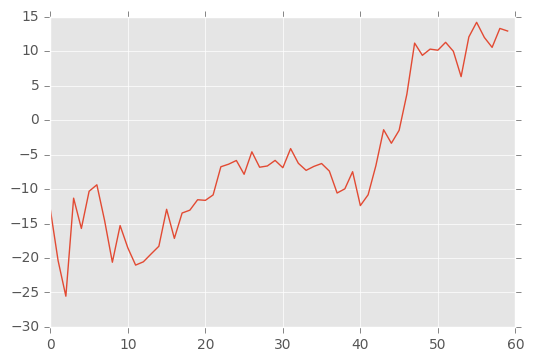

In [235]:
resids_arima = get_resids_arima(train, arima_model, d=2)
plt.plot(resids_arima)
plt.show()

In [236]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.0920
Epoch 2/100
0s - loss: 0.0699
Epoch 3/100
0s - loss: 0.0671
Epoch 4/100
0s - loss: 0.0671
Epoch 5/100
0s - loss: 0.0644
Epoch 6/100
0s - loss: 0.0696
Epoch 7/100
0s - loss: 0.0667
Epoch 8/100
0s - loss: 0.0639
Epoch 9/100
0s - loss: 0.0632
Epoch 10/100
0s - loss: 0.0670
Epoch 11/100
0s - loss: 0.0676
Epoch 12/100
0s - loss: 0.0644
Epoch 13/100
0s - loss: 0.0630
Epoch 14/100
0s - loss: 0.0629
Epoch 15/100
0s - loss: 0.0627
Epoch 16/100
0s - loss: 0.0569
Epoch 17/100
0s - loss: 0.0638
Epoch 18/100
0s - loss: 0.0617
Epoch 19/100
0s - loss: 0.0604
Epoch 20/100
0s - loss: 0.0592
Epoch 21/100
0s - loss: 0.0587
Epoch 22/100
0s - loss: 0.0568
Epoch 23/100
0s - loss: 0.0578
Epoch 24/100
0s - loss: 0.0540
Epoch 25/100
0s - loss: 0.0546
Epoch 26/100
0s - loss: 0.0526
Epoch 27/100
0s - loss: 0.0630
Epoch 28/100
0s - loss: 0.0542
Epoch 29/100
0s - loss: 0.0587
Epoch 30/100
0s - loss: 0.0510
Epoch 31/100
0s - loss: 0.0502
Epoch 32/100
0s - loss: 0.0626
Epoch 33/100
0s -

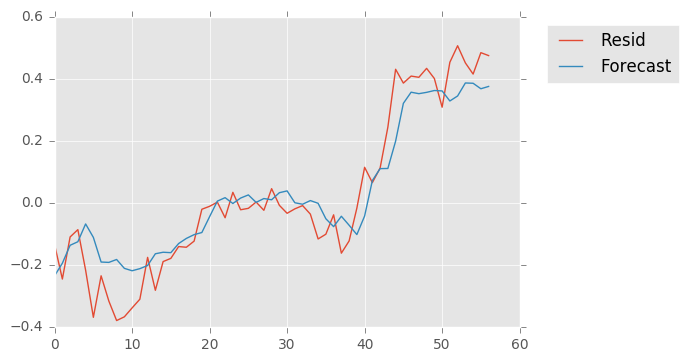

In [237]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [238]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

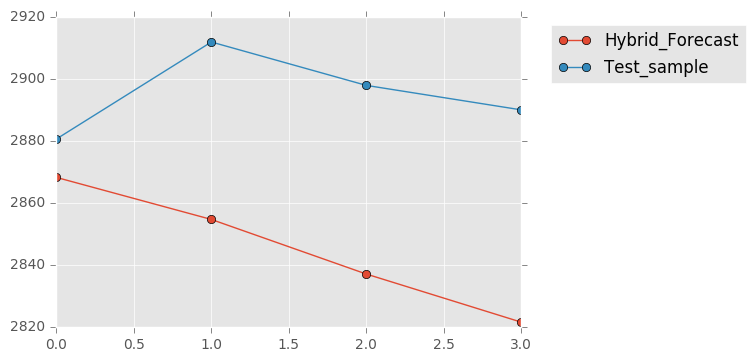

In [239]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [240]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 49.740329173249961, 'MSE': 2955.9683156471892}

---

---

---

# Personal Income and Its Disposition

In [310]:
pers_inc = df.iloc[48, 1:186].copy()
pers_inc.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   4.061463
p-value                          1.000000
#Lags Used                      12.000000
Number of Observations Used    172.000000
Critical Value (10%)            -2.575809
Critical Value (5%)             -2.878495
Critical Value (1%)             -3.468952
dtype: float64


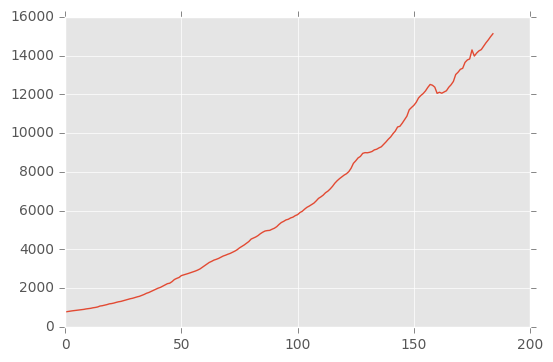

In [311]:
test_stationarity(pers_inc)

Results of Dickey-Fuller Test:
Test Statistic                  -2.563036
p-value                          0.100880
#Lags Used                      14.000000
Number of Observations Used    169.000000
Critical Value (10%)            -2.575971
Critical Value (5%)             -2.878799
Critical Value (1%)             -3.469648
dtype: float64


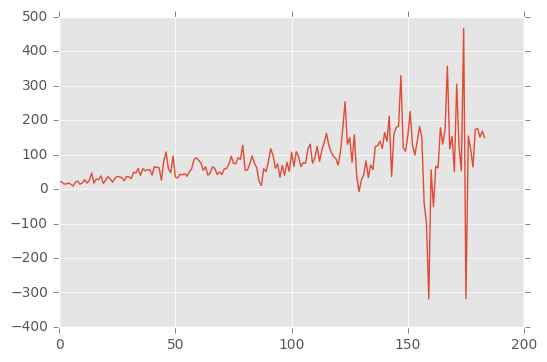

In [312]:
test_stationarity(diff_series(pers_inc))

Results of Dickey-Fuller Test:
Test Statistic                -6.837962e+00
p-value                        1.821920e-09
#Lags Used                     1.400000e+01
Number of Observations Used    1.680000e+02
Critical Value (10%)          -2.576027e+00
Critical Value (5%)           -2.878903e+00
Critical Value (1%)           -3.469886e+00
dtype: float64


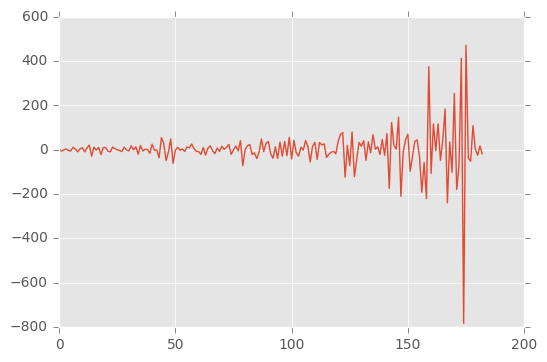

In [313]:
test_stationarity(diff_series(diff_series(pers_inc)))

In [492]:
train = pers_inc[:-9]
test = pers_inc[-9:]

### ARIMA

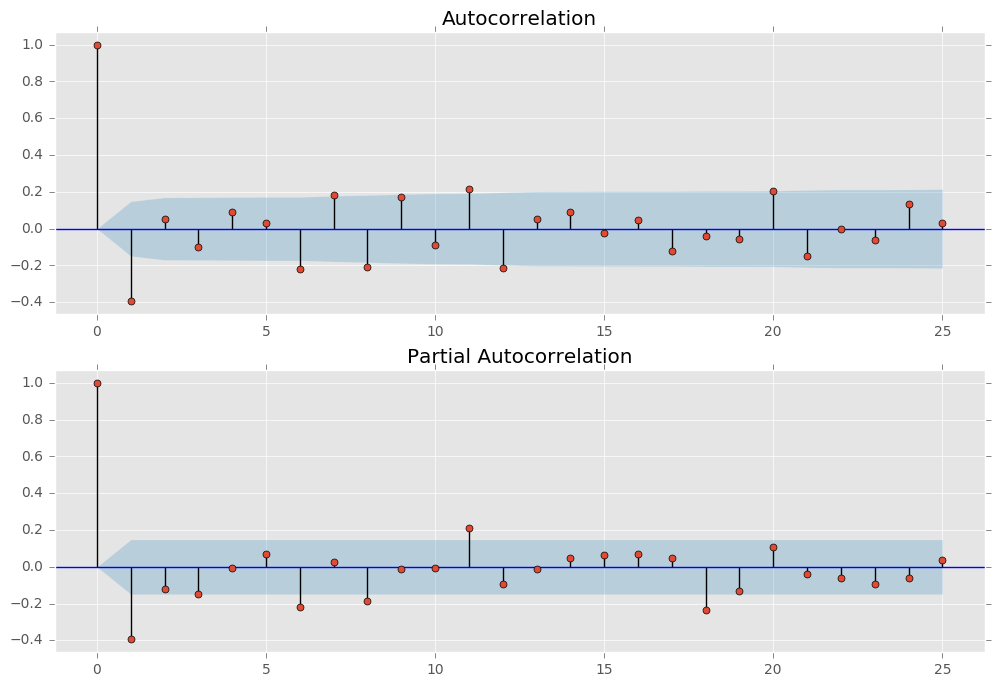

In [317]:
correlogram(diff_series(diff_series(train)))

In [342]:
arima_model = ARIMA(np.array(train), order=(1,2,2)).fit(trend='nc')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  174
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -968.664
Method:                       css-mle   S.D. of innovations             63.096
Date:                Sat, 28 Jan 2017   AIC                           1945.329
Time:                        23:49:26   BIC                           1957.965
Sample:                             2   HQIC                          1950.455
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D2.y    -0.9184      0.051    -17.942      0.000        -1.019    -0.818
ma.L1.D2.y     0.3600      0.088      4.083      0.000         0.187     0.533
ma.L2.D2.y    -0.6184      0.077     -8.069      0.0

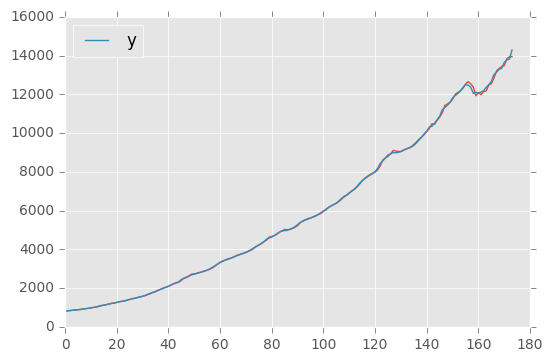

In [343]:
arima_model.plot_predict()
plt.show()

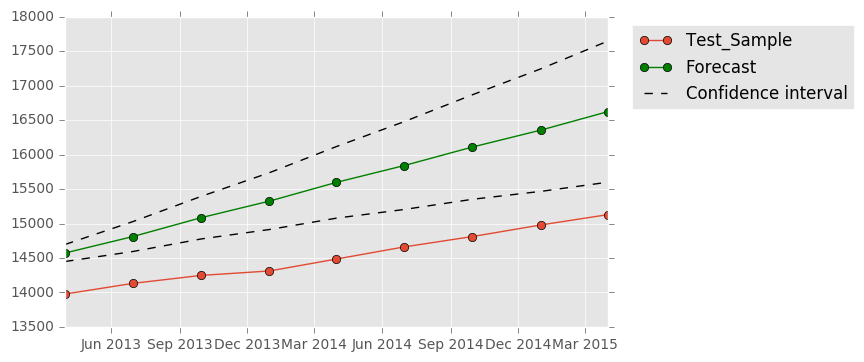

In [344]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [345]:
errors_out_sample(test, forc_arima[0])

{'MAE': 1065.7303376178138, 'MSE': 1221927.5661761612}

### ANN

In [493]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.1131
Epoch 2/100
0s - loss: 0.0895
Epoch 3/100
0s - loss: 0.0923
Epoch 4/100
0s - loss: 0.0887
Epoch 5/100
0s - loss: 0.0903
Epoch 6/100
0s - loss: 0.0876
Epoch 7/100
0s - loss: 0.0843
Epoch 8/100
0s - loss: 0.0847
Epoch 9/100
0s - loss: 0.0792
Epoch 10/100
0s - loss: 0.0801
Epoch 11/100
0s - loss: 0.0691
Epoch 12/100
0s - loss: 0.0712
Epoch 13/100
0s - loss: 0.0626
Epoch 14/100
0s - loss: 0.0568
Epoch 15/100
0s - loss: 0.0439
Epoch 16/100
0s - loss: 0.0294
Epoch 17/100
0s - loss: 0.0341
Epoch 18/100
0s - loss: 0.0301
Epoch 19/100
0s - loss: 0.0275
Epoch 20/100
0s - loss: 0.0308
Epoch 21/100
0s - loss: 0.0287
Epoch 22/100
0s - loss: 0.0218
Epoch 23/100
0s - loss: 0.0228
Epoch 24/100
0s - loss: 0.0276
Epoch 25/100
0s - loss: 0.0198
Epoch 26/100
0s - loss: 0.0203
Epoch 27/100
0s - loss: 0.0217
Epoch 28/100
0s - loss: 0.0174
Epoch 29/100
0s - loss: 0.0156
Epoch 30/100
0s - loss: 0.0181
Epoch 31/100
0s - loss: 0.0167
Epoch 32/100
0s - loss: 0.0212
Epoch 33/100
0s -

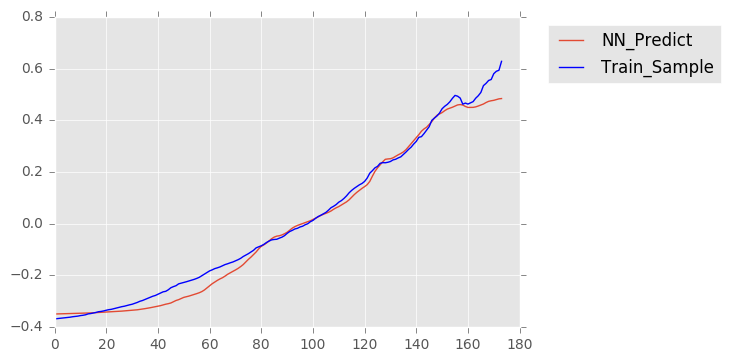

In [494]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

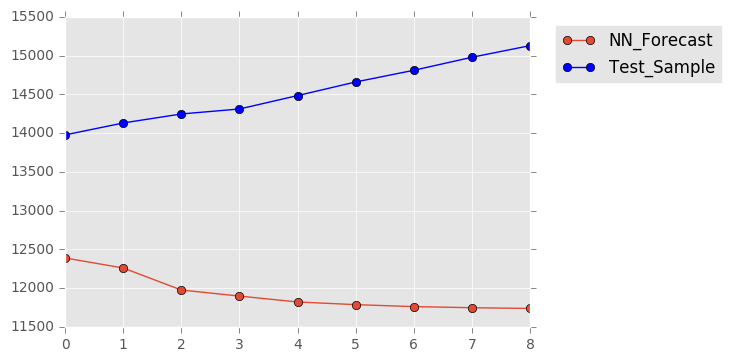

In [495]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [496]:
errors_out_sample(test, forc_arima[0])

{'MAE': 6987.1847489337433, 'MSE': 48838365.931372486}

### Hybrid

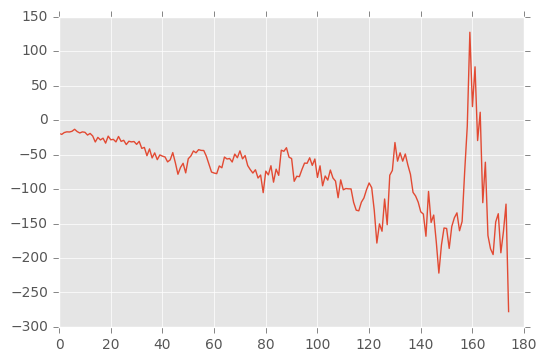

In [359]:
resids_arima = get_resids_arima(train, arima_model, d=2)
plt.plot(resids_arima)
plt.show()

In [390]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 4

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.4687
Epoch 2/100
0s - loss: 0.0402
Epoch 3/100
0s - loss: 0.0321
Epoch 4/100
0s - loss: 0.0254
Epoch 5/100
0s - loss: 0.0243
Epoch 6/100
0s - loss: 0.0187
Epoch 7/100
0s - loss: 0.0217
Epoch 8/100
0s - loss: 0.0205
Epoch 9/100
0s - loss: 0.0204
Epoch 10/100
0s - loss: 0.0190
Epoch 11/100
0s - loss: 0.0184
Epoch 12/100
0s - loss: 0.0177
Epoch 13/100
0s - loss: 0.0176
Epoch 14/100
0s - loss: 0.0176
Epoch 15/100
0s - loss: 0.0171
Epoch 16/100
0s - loss: 0.0182
Epoch 17/100
0s - loss: 0.0179
Epoch 18/100
0s - loss: 0.0171
Epoch 19/100
0s - loss: 0.0164
Epoch 20/100
0s - loss: 0.0174
Epoch 21/100
0s - loss: 0.0177
Epoch 22/100
0s - loss: 0.0174
Epoch 23/100
0s - loss: 0.0183
Epoch 24/100
0s - loss: 0.0177
Epoch 25/100
0s - loss: 0.0171
Epoch 26/100
0s - loss: 0.0169
Epoch 27/100
0s - loss: 0.0167
Epoch 28/100
0s - loss: 0.0170
Epoch 29/100
0s - loss: 0.0166
Epoch 30/100
0s - loss: 0.0159
Epoch 31/100
0s - loss: 0.0160
Epoch 32/100
0s - loss: 0.0156
Epoch 33/100
0s -

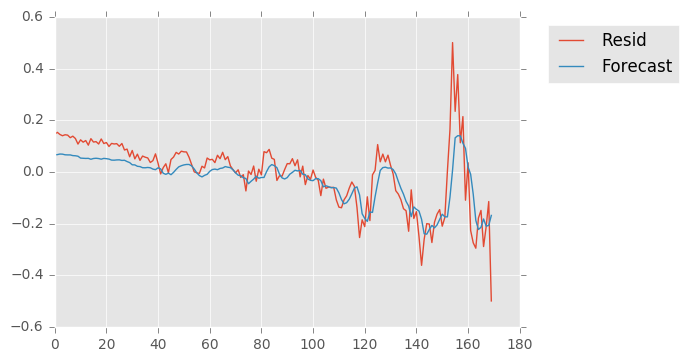

In [391]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [392]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

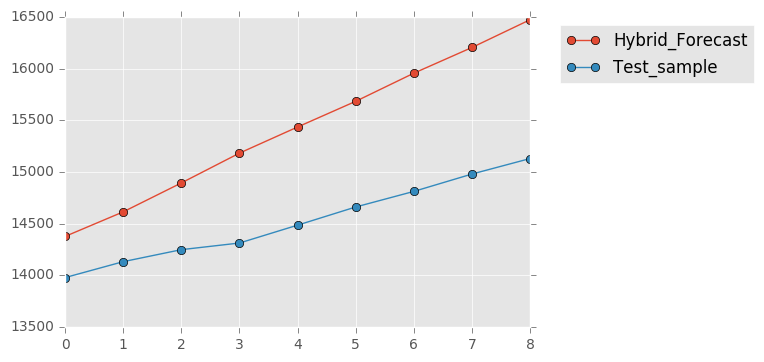

In [393]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [394]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 897.90668005216708, 'MSE': 903027.80959665019}

In [397]:
nn_resids_forecast

array([-197.32269287, -197.32269287, -192.06793213, -144.26533508,
       -163.31016541, -158.02134705, -155.26098633, -152.0018158 ,
       -150.83995056], dtype=float32)

---

---

---

# Wages and salaries

In [405]:
wages = df.iloc[49, 1:186].copy()
wages.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   2.094862
p-value                          0.998784
#Lags Used                      14.000000
Number of Observations Used    170.000000
Critical Value (10%)            -2.575917
Critical Value (5%)             -2.878696
Critical Value (1%)             -3.469413
dtype: float64


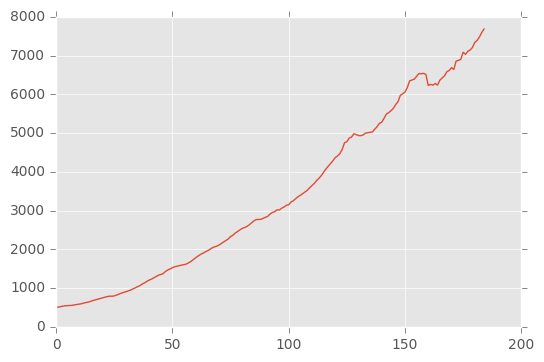

In [406]:
test_stationarity(wages)

Results of Dickey-Fuller Test:
Test Statistic                  -2.624336
p-value                          0.088071
#Lags Used                      13.000000
Number of Observations Used    170.000000
Critical Value (10%)            -2.575917
Critical Value (5%)             -2.878696
Critical Value (1%)             -3.469413
dtype: float64


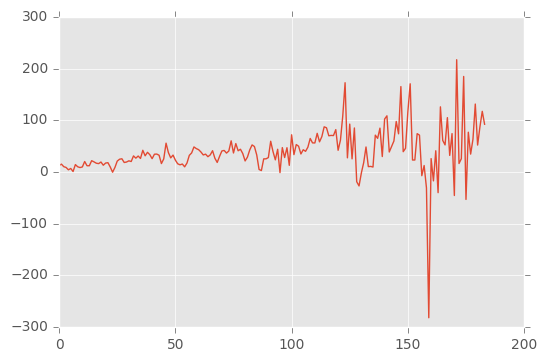

In [407]:
test_stationarity(diff_series(wages))

Results of Dickey-Fuller Test:
Test Statistic                -5.853942e+00
p-value                        3.536029e-07
#Lags Used                     1.200000e+01
Number of Observations Used    1.700000e+02
Critical Value (10%)          -2.575917e+00
Critical Value (5%)           -2.878696e+00
Critical Value (1%)           -3.469413e+00
dtype: float64


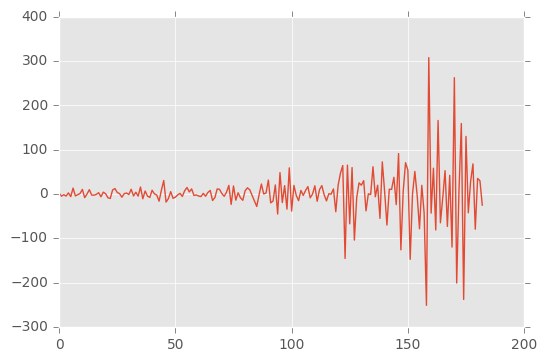

In [408]:
test_stationarity(diff_series(diff_series(wages)))

In [497]:
train = wages[:-9]
test = wages[-9:]

### ARIMA

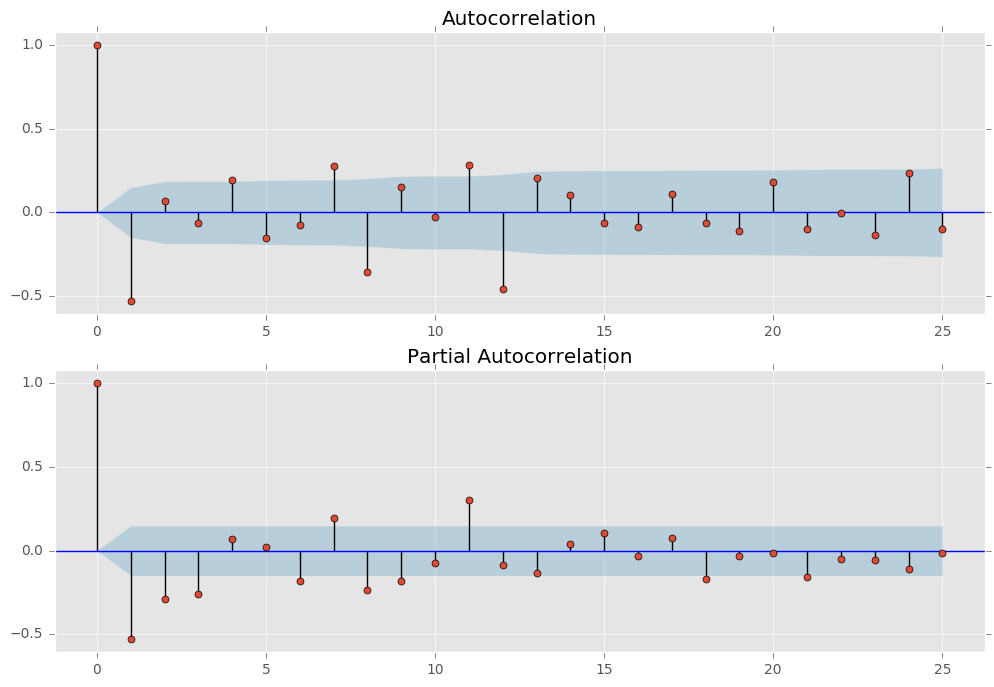

In [421]:
correlogram(diff_series(diff_series(train)))

In [482]:
arima_model = ARIMA(np.array(train), order=(2,2,1)).fit(trend='nc')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  174
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -900.330
Method:                       css-mle   S.D. of innovations             42.657
Date:                Sun, 29 Jan 2017   AIC                           1808.660
Time:                        00:44:21   BIC                           1821.297
Sample:                             2   HQIC                          1813.786
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D2.y    -0.2611      0.223     -1.173      0.242        -0.697     0.175
ar.L2.D2.y    -0.0753      0.167     -0.451      0.653        -0.403     0.252
ma.L1.D2.y    -0.5587      0.216     -2.586      0.0

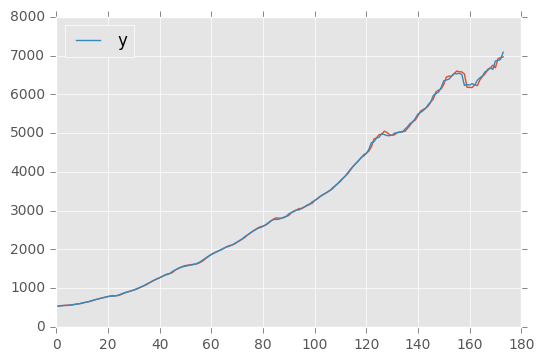

In [483]:
arima_model.plot_predict()
plt.show()

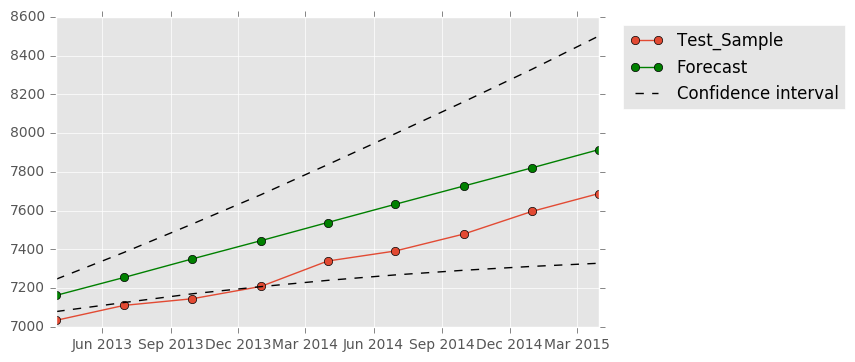

In [484]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [485]:
errors_out_sample(test, forc_arima[0])

{'MAE': 206.02636217736847, 'MSE': 44059.652539840681}

### ANN

In [498]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.1106
Epoch 2/100
0s - loss: 0.0975
Epoch 3/100
0s - loss: 0.0850
Epoch 4/100
0s - loss: 0.0802
Epoch 5/100
0s - loss: 0.0955
Epoch 6/100
0s - loss: 0.0831
Epoch 7/100
0s - loss: 0.0772
Epoch 8/100
0s - loss: 0.0797
Epoch 9/100
0s - loss: 0.0671
Epoch 10/100
0s - loss: 0.0649
Epoch 11/100
0s - loss: 0.0603
Epoch 12/100
0s - loss: 0.0507
Epoch 13/100
0s - loss: 0.0468
Epoch 14/100
0s - loss: 0.0448
Epoch 15/100
0s - loss: 0.0542
Epoch 16/100
0s - loss: 0.0454
Epoch 17/100
0s - loss: 0.0343
Epoch 18/100
0s - loss: 0.0391
Epoch 19/100
0s - loss: 0.0378
Epoch 20/100
0s - loss: 0.0376
Epoch 21/100
0s - loss: 0.0362
Epoch 22/100
0s - loss: 0.0300
Epoch 23/100
0s - loss: 0.0337
Epoch 24/100
0s - loss: 0.0299
Epoch 25/100
0s - loss: 0.0357
Epoch 26/100
0s - loss: 0.0289
Epoch 27/100
0s - loss: 0.0249
Epoch 28/100
0s - loss: 0.0286
Epoch 29/100
0s - loss: 0.0313
Epoch 30/100
0s - loss: 0.0301
Epoch 31/100
0s - loss: 0.0232
Epoch 32/100
0s - loss: 0.0197
Epoch 33/100
0s -

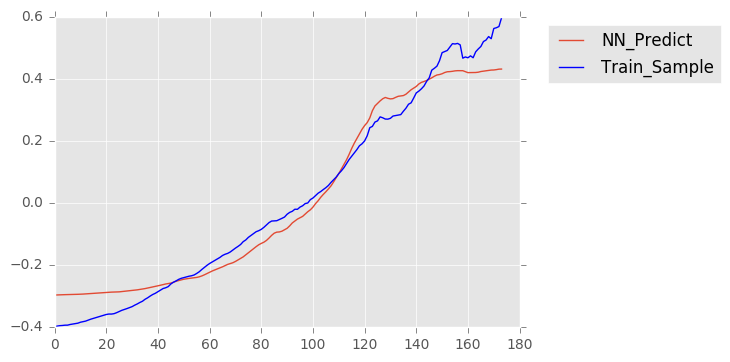

In [499]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

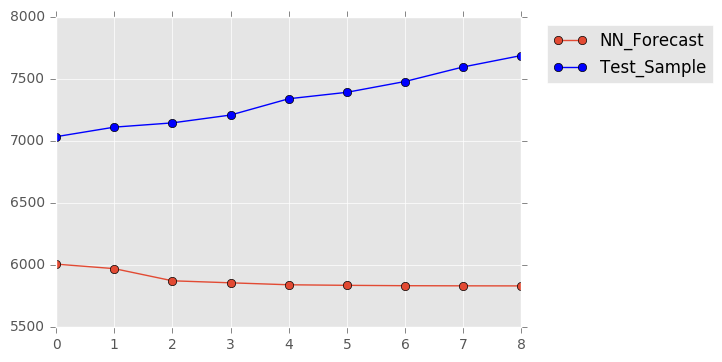

In [500]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [501]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 8091.1177911632776, 'MSE': 65685813.906355776}

### Hybrid

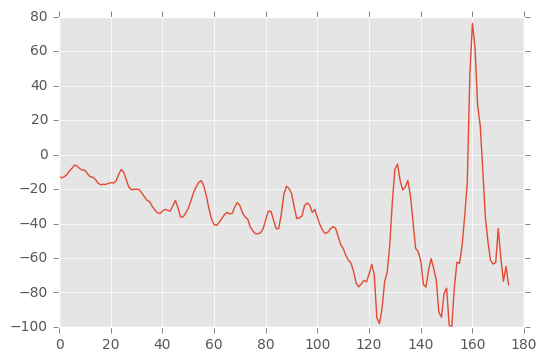

In [502]:
resids_arima = get_resids_arima(train, arima_model, d=2)
plt.plot(resids_arima)
plt.show()

In [503]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
2s - loss: 0.1873
Epoch 2/100
0s - loss: 0.0545
Epoch 3/100
0s - loss: 0.0427
Epoch 4/100
0s - loss: 0.0351
Epoch 5/100
0s - loss: 0.0299
Epoch 6/100
0s - loss: 0.0273
Epoch 7/100
0s - loss: 0.0255
Epoch 8/100
0s - loss: 0.0249
Epoch 9/100
0s - loss: 0.0253
Epoch 10/100
0s - loss: 0.0247
Epoch 11/100
0s - loss: 0.0248
Epoch 12/100
0s - loss: 0.0235
Epoch 13/100
0s - loss: 0.0224
Epoch 14/100
0s - loss: 0.0245
Epoch 15/100
0s - loss: 0.0229
Epoch 16/100
0s - loss: 0.0222
Epoch 17/100
0s - loss: 0.0236
Epoch 18/100
0s - loss: 0.0208
Epoch 19/100
0s - loss: 0.0224
Epoch 20/100
0s - loss: 0.0229
Epoch 21/100
0s - loss: 0.0216
Epoch 22/100
0s - loss: 0.0226
Epoch 23/100
0s - loss: 0.0211
Epoch 24/100
0s - loss: 0.0223
Epoch 25/100
0s - loss: 0.0198
Epoch 26/100
0s - loss: 0.0209
Epoch 27/100
0s - loss: 0.0208
Epoch 28/100
0s - loss: 0.0221
Epoch 29/100
0s - loss: 0.0211
Epoch 30/100
0s - loss: 0.0203
Epoch 31/100
0s - loss: 0.0198
Epoch 32/100
0s - loss: 0.0196
Epoch 33/100
0s -

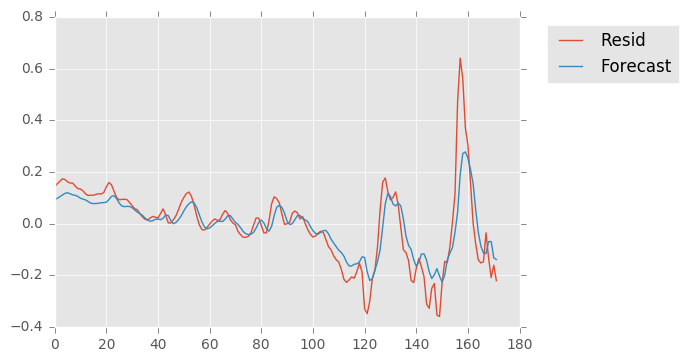

In [504]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [505]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

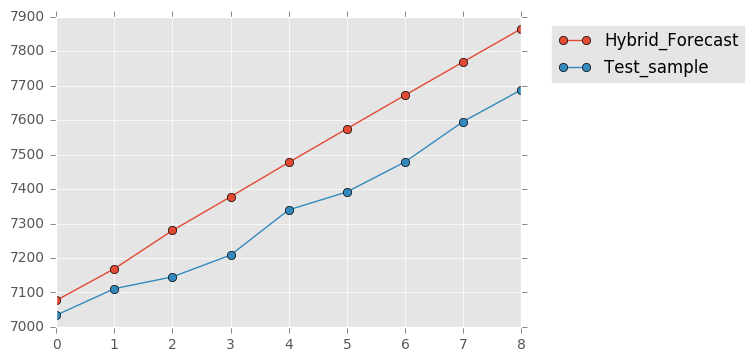

In [506]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [507]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 141.15109896325714, 'MSE': 22628.521059064551}

In [508]:
nn_resids_forecast

array([-86.10334778, -86.10334778, -71.09324646, -66.83618164,
       -61.0412178 , -57.51320267, -54.17682266, -51.61431122, -49.39569092], dtype=float32)

---

---

---

# Personal consumption expenditures (PCE)

In [517]:
pers_consump_exp = df.iloc[55, 1:186].copy()
pers_consump_exp.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   0.975815
p-value                          0.994004
#Lags Used                       3.000000
Number of Observations Used    181.000000
Critical Value (10%)            -2.575355
Critical Value (5%)             -2.877644
Critical Value (1%)             -3.467005
dtype: float64


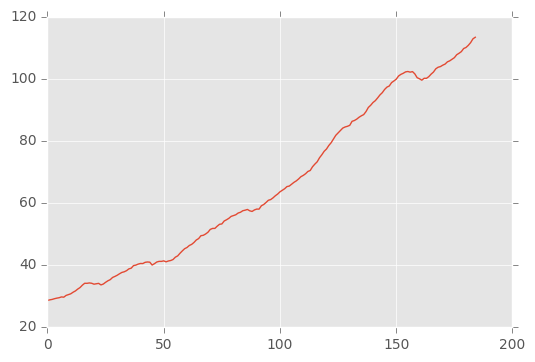

In [518]:
test_stationarity(pers_consump_exp)

Results of Dickey-Fuller Test:
Test Statistic                  -3.731468
p-value                          0.003692
#Lags Used                       2.000000
Number of Observations Used    181.000000
Critical Value (10%)            -2.575355
Critical Value (5%)             -2.877644
Critical Value (1%)             -3.467005
dtype: float64


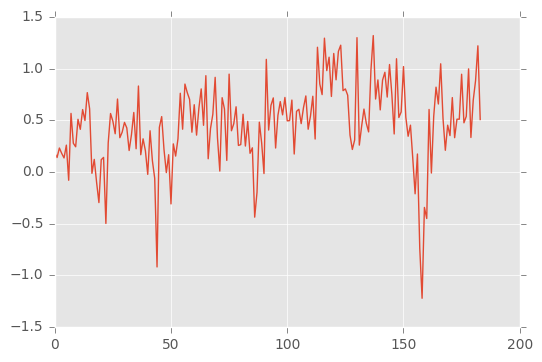

In [519]:
test_stationarity(diff_series(pers_consump_exp))

In [586]:
train = pers_consump_exp[:-9]
test = pers_consump_exp[-9:]

### ARIMA

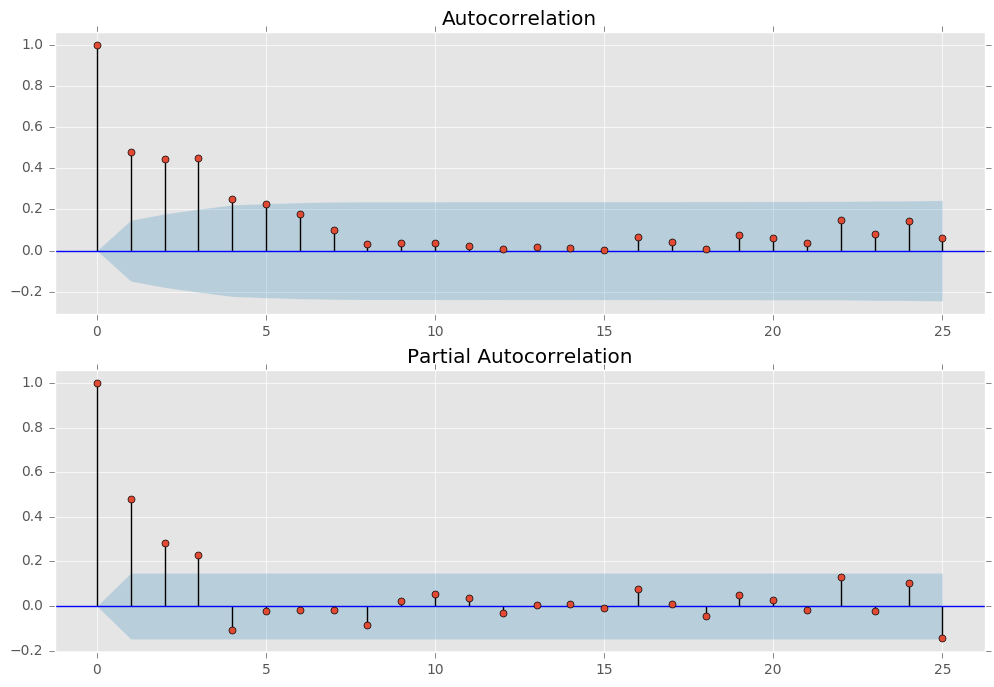

In [587]:
correlogram(diff_series(train))

In [596]:
arima_model = ARIMA(np.array(train), order=(4,1,1)).fit(trend='nc')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 -57.074
Method:                       css-mle   S.D. of innovations              0.334
Date:                Sun, 29 Jan 2017   AIC                            126.147
Time:                        02:07:11   BIC                            145.136
Sample:                             1   HQIC                           133.849
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y     -0.3401      0.572     -0.594      0.553        -1.462     0.781
ar.L2.D.y      0.5146      0.194      2.650      0.009         0.134     0.895
ar.L3.D.y      0.4902      0.153      3.211      0.0

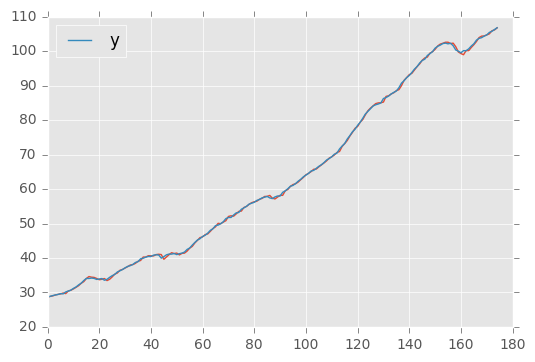

In [597]:
arima_model.plot_predict()
plt.show()

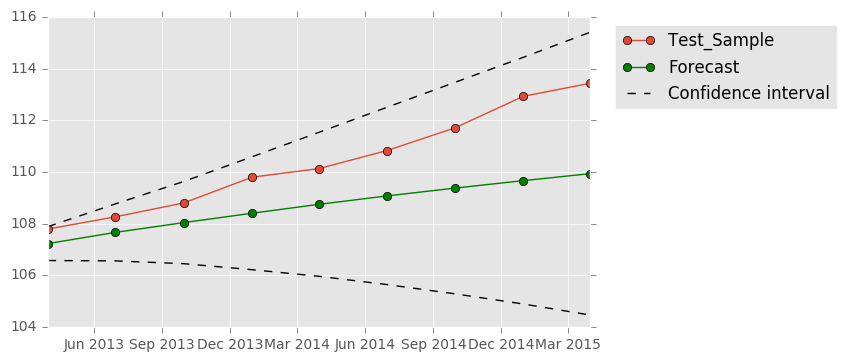

In [598]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [599]:
errors_out_sample(test, forc_arima[0])

{'MAE': 1.7282073885857758, 'MSE': 4.0591636832557993}

### ANN

In [552]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.2994
Epoch 2/100
0s - loss: 0.1154
Epoch 3/100
0s - loss: 0.1104
Epoch 4/100
0s - loss: 0.1068
Epoch 5/100
0s - loss: 0.1021
Epoch 6/100
0s - loss: 0.1016
Epoch 7/100
0s - loss: 0.0982
Epoch 8/100
0s - loss: 0.1036
Epoch 9/100
0s - loss: 0.0945
Epoch 10/100
0s - loss: 0.0865
Epoch 11/100
0s - loss: 0.0815
Epoch 12/100
0s - loss: 0.0796
Epoch 13/100
0s - loss: 0.0753
Epoch 14/100
0s - loss: 0.0579
Epoch 15/100
0s - loss: 0.0603
Epoch 16/100
0s - loss: 0.0488
Epoch 17/100
0s - loss: 0.0418
Epoch 18/100
0s - loss: 0.0438
Epoch 19/100
0s - loss: 0.0366
Epoch 20/100
0s - loss: 0.0300
Epoch 21/100
0s - loss: 0.0420
Epoch 22/100
0s - loss: 0.0305
Epoch 23/100
0s - loss: 0.0294
Epoch 24/100
0s - loss: 0.0280
Epoch 25/100
0s - loss: 0.0327
Epoch 26/100
0s - loss: 0.0263
Epoch 27/100
0s - loss: 0.0244
Epoch 28/100
0s - loss: 0.0236
Epoch 29/100
0s - loss: 0.0261
Epoch 30/100
0s - loss: 0.0215
Epoch 31/100
0s - loss: 0.0235
Epoch 32/100
0s - loss: 0.0203
Epoch 33/100
0s -

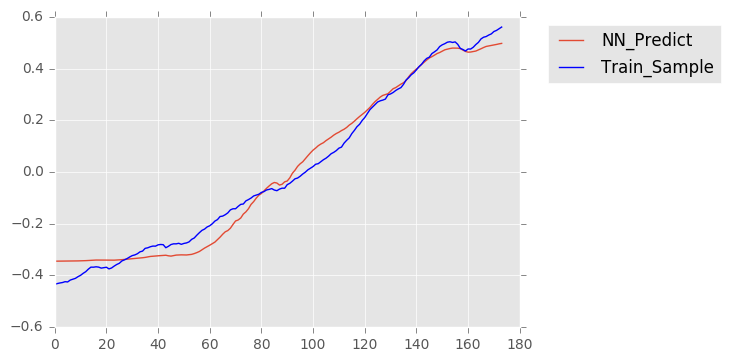

In [553]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

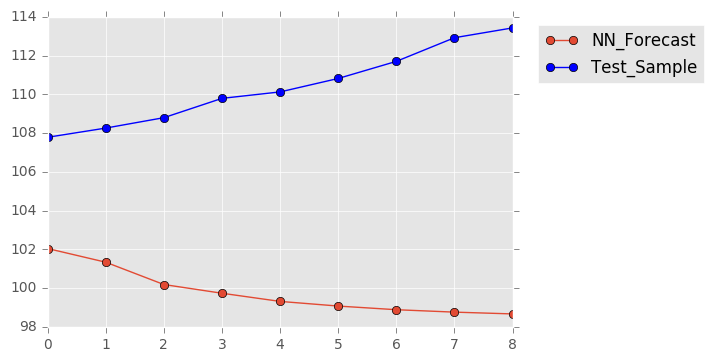

In [554]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [555]:
errors_out_sample(test, nn_forecast)

{'MAE': 10.626571607801649, 'MSE': 121.55495952439641}

### Hybrid

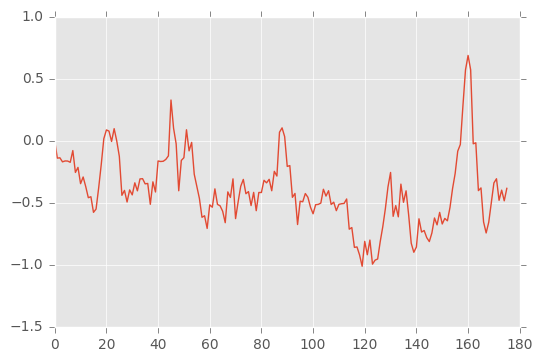

In [601]:
resids_arima = get_resids_arima(train, arima_model, d=1)
plt.plot(resids_arima)
plt.show()

In [602]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
2s - loss: 0.3425
Epoch 2/100
0s - loss: 0.1582
Epoch 3/100
0s - loss: 0.1265
Epoch 4/100
0s - loss: 0.1189
Epoch 5/100
0s - loss: 0.1203
Epoch 6/100
0s - loss: 0.0707
Epoch 7/100
0s - loss: 0.0615
Epoch 8/100
0s - loss: 0.0432
Epoch 9/100
0s - loss: 0.0460
Epoch 10/100
0s - loss: 0.0437
Epoch 11/100
0s - loss: 0.0401
Epoch 12/100
0s - loss: 0.0408
Epoch 13/100
0s - loss: 0.0391
Epoch 14/100
0s - loss: 0.0360
Epoch 15/100
0s - loss: 0.0348
Epoch 16/100
0s - loss: 0.0348
Epoch 17/100
0s - loss: 0.0328
Epoch 18/100
0s - loss: 0.0343
Epoch 19/100
0s - loss: 0.0351
Epoch 20/100
0s - loss: 0.0294
Epoch 21/100
0s - loss: 0.0322
Epoch 22/100
0s - loss: 0.0295
Epoch 23/100
0s - loss: 0.0313
Epoch 24/100
0s - loss: 0.0305
Epoch 25/100
0s - loss: 0.0301
Epoch 26/100
0s - loss: 0.0312
Epoch 27/100
0s - loss: 0.0302
Epoch 28/100
0s - loss: 0.0305
Epoch 29/100
0s - loss: 0.0294
Epoch 30/100
0s - loss: 0.0299
Epoch 31/100
0s - loss: 0.0303
Epoch 32/100
0s - loss: 0.0296
Epoch 33/100
0s -

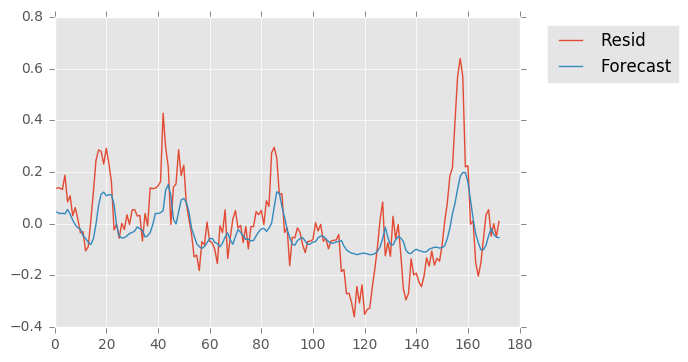

In [603]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [604]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

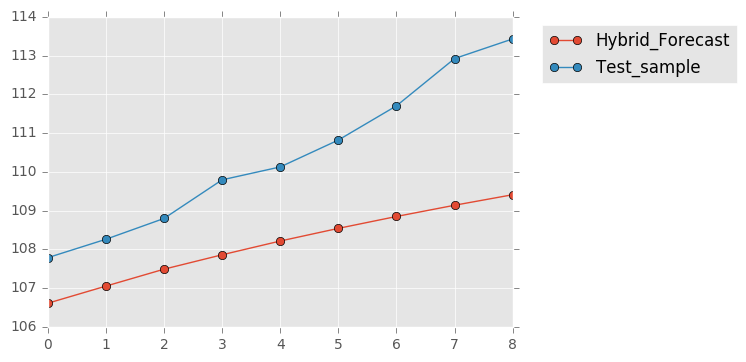

In [605]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [606]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 2.2756761965479817, 'MSE': 6.2002452576539424}

In [607]:
nn_resids_forecast

array([-0.61348492, -0.60577816, -0.54837602, -0.53890741, -0.52868181,
       -0.52535295, -0.52305663, -0.52207565, -0.52150571], dtype=float32)

---

---

---

# Real Personal Consumption Expenditures by Major Type of Product, Quantity Indexes

# Goods

In [582]:
pers_goods = df.iloc[56, 1:186].copy()
pers_goods.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   1.222984
p-value                          0.996141
#Lags Used                       3.000000
Number of Observations Used    181.000000
Critical Value (10%)            -2.575355
Critical Value (5%)             -2.877644
Critical Value (1%)             -3.467005
dtype: float64


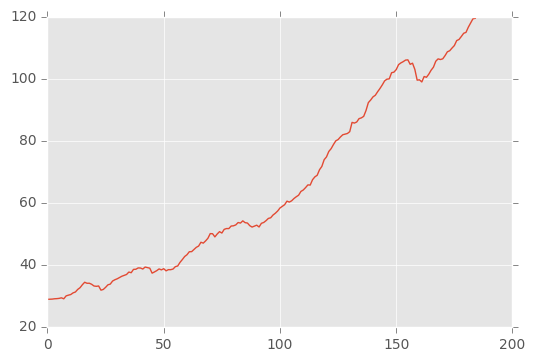

In [583]:
test_stationarity(pers_goods)

Results of Dickey-Fuller Test:
Test Statistic                  -4.720413
p-value                          0.000077
#Lags Used                       2.000000
Number of Observations Used    181.000000
Critical Value (10%)            -2.575355
Critical Value (5%)             -2.877644
Critical Value (1%)             -3.467005
dtype: float64


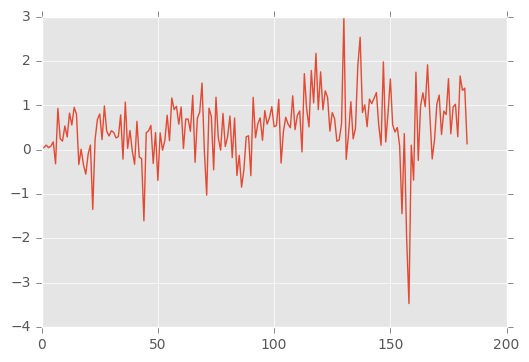

In [584]:
test_stationarity(diff_series(pers_goods))

In [585]:
train = pers_consump_exp[:-9]
test = pers_consump_exp[-9:]

### ARIMA

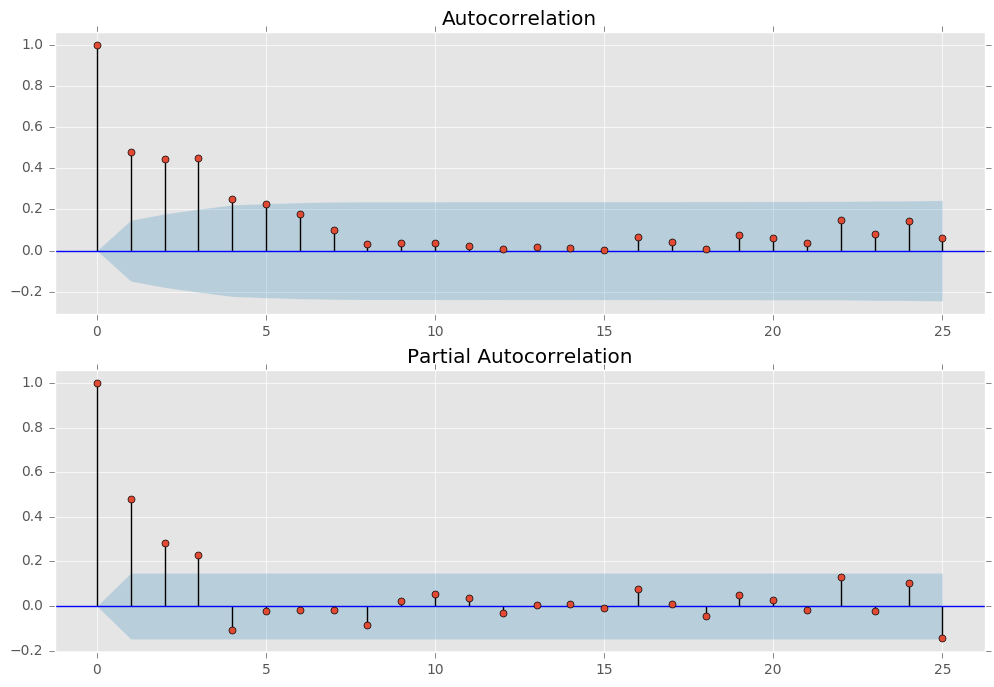

In [608]:
correlogram(diff_series(train))

In [621]:
arima_model = ARIMA(np.array(train), order=(3,1,0)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -52.420
Method:                       css-mle   S.D. of innovations              0.326
Date:                Sun, 29 Jan 2017   AIC                            114.839
Time:                        02:17:00   BIC                            130.663
Sample:                             1   HQIC                           121.258
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4414      0.082      5.382      0.000         0.281     0.602
ar.L1.D.y      0.2768      0.073      3.778      0.000         0.133     0.420
ar.L2.D.y      0.2041      0.075      2.737      0.0

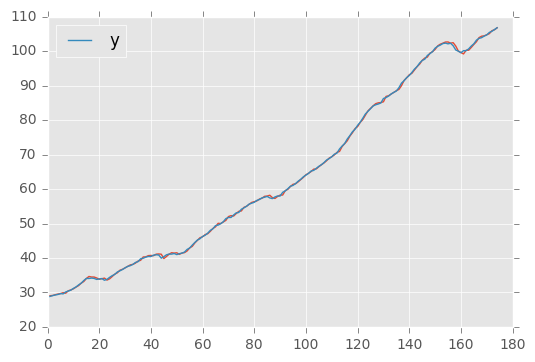

In [623]:
arima_model.plot_predict()
plt.show()

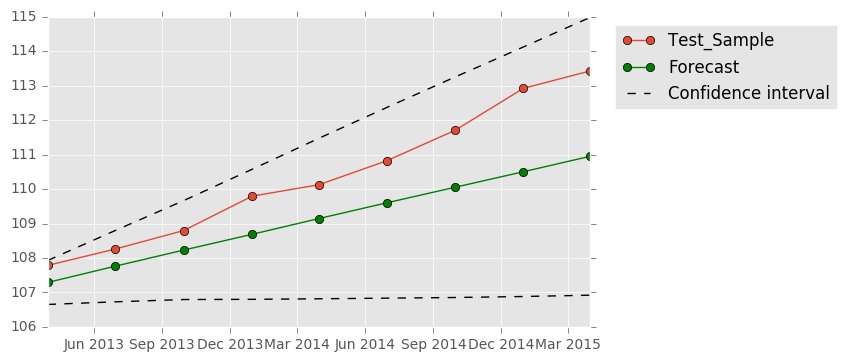

In [624]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [625]:
errors_out_sample(test, forc_arima[0])

{'MAE': 1.2690263195914657, 'MSE': 2.136314488701311}

---

---

---

### ANN

In [635]:
scaled_train = scaler(train)[0]

lags_for_nn = 3

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
2s - loss: 0.1902
Epoch 2/100
0s - loss: 0.1112
Epoch 3/100
0s - loss: 0.1063
Epoch 4/100
0s - loss: 0.0993
Epoch 5/100
0s - loss: 0.0977
Epoch 6/100
0s - loss: 0.0917
Epoch 7/100
0s - loss: 0.0846
Epoch 8/100
0s - loss: 0.0749
Epoch 9/100
0s - loss: 0.0717
Epoch 10/100
0s - loss: 0.0561
Epoch 11/100
0s - loss: 0.0418
Epoch 12/100
0s - loss: 0.0388
Epoch 13/100
0s - loss: 0.0344
Epoch 14/100
0s - loss: 0.0363
Epoch 15/100
0s - loss: 0.0284
Epoch 16/100
0s - loss: 0.0230
Epoch 17/100
0s - loss: 0.0232
Epoch 18/100
0s - loss: 0.0167
Epoch 19/100
0s - loss: 0.0234
Epoch 20/100
0s - loss: 0.0227
Epoch 21/100
0s - loss: 0.0199
Epoch 22/100
0s - loss: 0.0223
Epoch 23/100
0s - loss: 0.0277
Epoch 24/100
0s - loss: 0.0191
Epoch 25/100
0s - loss: 0.0160
Epoch 26/100
0s - loss: 0.0170
Epoch 27/100
0s - loss: 0.0227
Epoch 28/100
0s - loss: 0.0199
Epoch 29/100
0s - loss: 0.0180
Epoch 30/100
0s - loss: 0.0197
Epoch 31/100
0s - loss: 0.0199
Epoch 32/100
0s - loss: 0.0155
Epoch 33/100
0s -

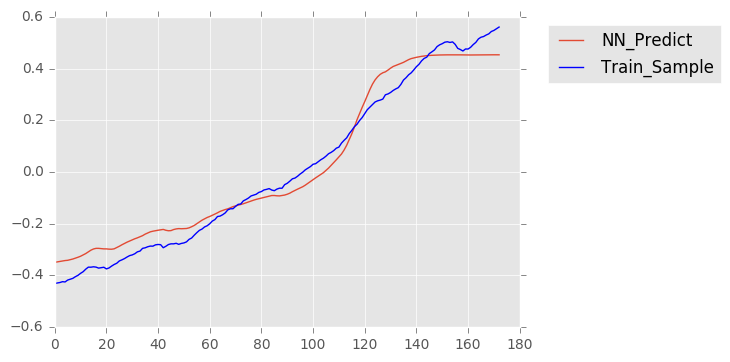

In [636]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

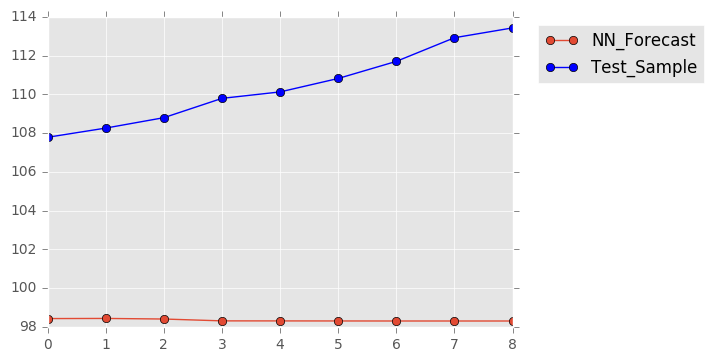

In [637]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [638]:
errors_out_sample(test, nn_forecast)

{'MAE': 12.060408650716147, 'MSE': 149.17030466181689}

### Hybrid

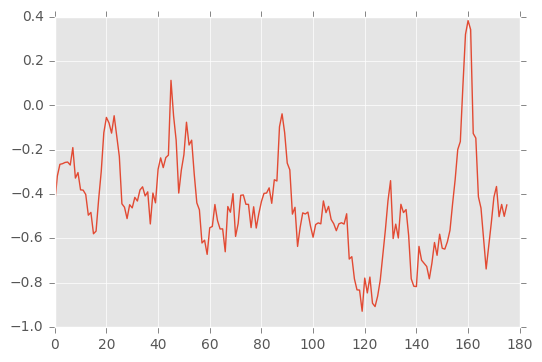

In [641]:
resids_arima = get_resids_arima(train, arima_model)
plt.plot(resids_arima)
plt.show()

In [642]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
2s - loss: 0.0567
Epoch 2/100
0s - loss: 0.0390
Epoch 3/100
0s - loss: 0.0380
Epoch 4/100
0s - loss: 0.0328
Epoch 5/100
0s - loss: 0.0305
Epoch 6/100
0s - loss: 0.0277
Epoch 7/100
0s - loss: 0.0292
Epoch 8/100
0s - loss: 0.0296
Epoch 9/100
0s - loss: 0.0262
Epoch 10/100
0s - loss: 0.0277
Epoch 11/100
0s - loss: 0.0310
Epoch 12/100
0s - loss: 0.0280
Epoch 13/100
0s - loss: 0.0288
Epoch 14/100
0s - loss: 0.0262
Epoch 15/100
0s - loss: 0.0280
Epoch 16/100
0s - loss: 0.0293
Epoch 17/100
0s - loss: 0.0271
Epoch 18/100
0s - loss: 0.0239
Epoch 19/100
0s - loss: 0.0260
Epoch 20/100
0s - loss: 0.0251
Epoch 21/100
0s - loss: 0.0254
Epoch 22/100
0s - loss: 0.0257
Epoch 23/100
0s - loss: 0.0217
Epoch 24/100
0s - loss: 0.0234
Epoch 25/100
0s - loss: 0.0225
Epoch 26/100
0s - loss: 0.0208
Epoch 27/100
0s - loss: 0.0241
Epoch 28/100
0s - loss: 0.0210
Epoch 29/100
0s - loss: 0.0226
Epoch 30/100
0s - loss: 0.0220
Epoch 31/100
0s - loss: 0.0213
Epoch 32/100
0s - loss: 0.0208
Epoch 33/100
0s -

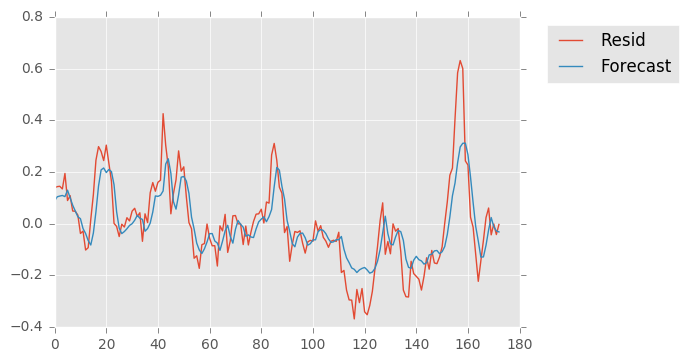

In [643]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [644]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

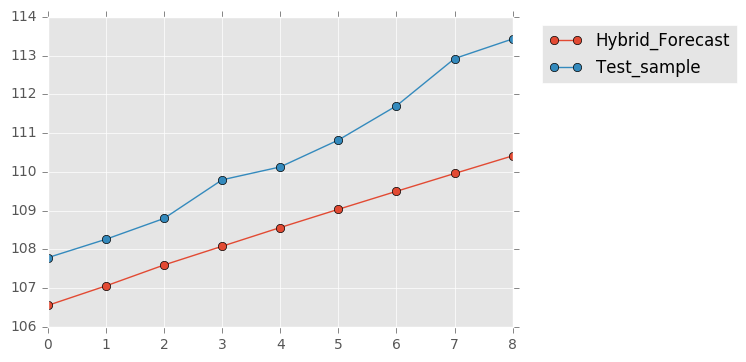

In [645]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [646]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 1.8767258926314743, 'MSE': 3.9724706265821035}

In [648]:
nn_resids_forecast

array([-0.73627406, -0.70612919, -0.63365126, -0.6071232 , -0.58183253,
       -0.56641519, -0.55412376, -0.54529291, -0.53845406], dtype=float32)

---

---

---

# Household consumption expenditures (for services)

In [3]:
hh_consump_serv = df.iloc[58, 1:186].copy()
hh_consump_serv.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   0.742798
p-value                          0.990654
#Lags Used                       6.000000
Number of Observations Used    178.000000
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
Critical Value (1%)             -3.467632
dtype: float64


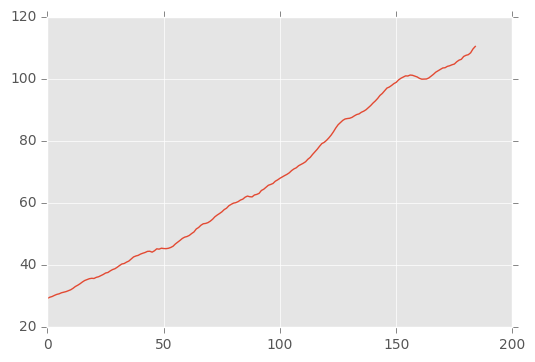

In [4]:
test_stationarity(hh_consump_serv)

Results of Dickey-Fuller Test:
Test Statistic                  -3.408599
p-value                          0.010669
#Lags Used                       5.000000
Number of Observations Used    178.000000
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
Critical Value (1%)             -3.467632
dtype: float64


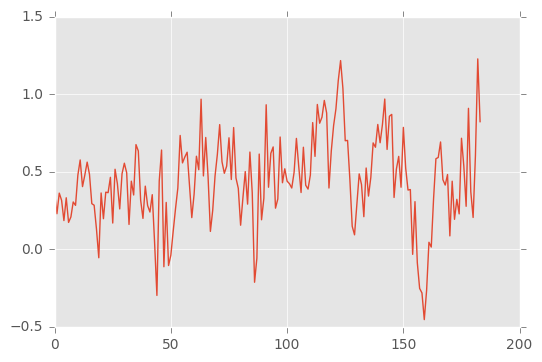

In [5]:
test_stationarity(diff_series(hh_consump_serv))

In [6]:
train = hh_consump_serv[:-9]
test = hh_consump_serv[-9:]

### ARIMA

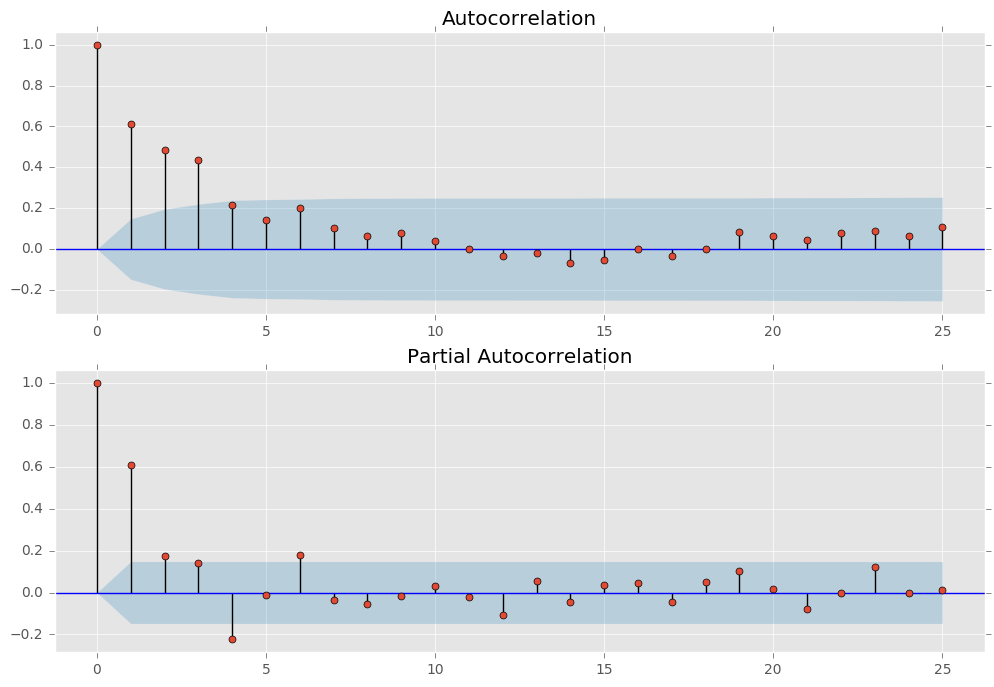

In [7]:
correlogram(diff_series(train))

In [8]:
arima_model = ARIMA(np.array(train), order=(2,1,1)).fit(trend='nc')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  12.017
Method:                       css-mle   S.D. of innovations              0.224
Date:                Sun, 29 Jan 2017   AIC                            -16.035
Time:                        03:02:23   BIC                             -3.375
Sample:                             1   HQIC                           -10.900
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.D.y      1.5426      0.081     18.969      0.000         1.383     1.702
ar.L2.D.y     -0.5439      0.080     -6.782      0.000        -0.701    -0.387
ma.L1.D.y     -0.9411      0.045    -21.131      0.0

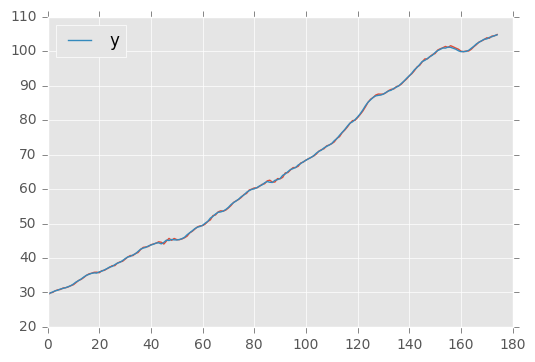

In [9]:
arima_model.plot_predict()
plt.show()

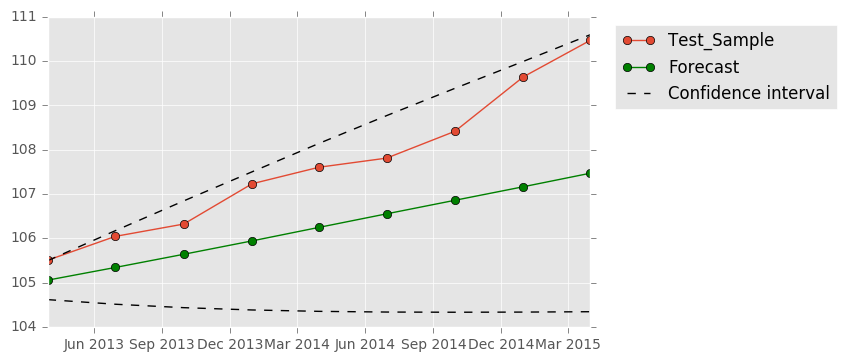

In [10]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [11]:
errors_out_sample(test, forc_arima[0])

{'MAE': 1.4200086097808855, 'MSE': 2.6485361131968301}

### ANN

In [12]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
1s - loss: 0.2817
Epoch 2/100
0s - loss: 0.1154
Epoch 3/100
0s - loss: 0.1260
Epoch 4/100
0s - loss: 0.1070
Epoch 5/100
0s - loss: 0.1099
Epoch 6/100
0s - loss: 0.1092
Epoch 7/100
0s - loss: 0.0997
Epoch 8/100
0s - loss: 0.0961
Epoch 9/100
0s - loss: 0.0947
Epoch 10/100
0s - loss: 0.0934
Epoch 11/100
0s - loss: 0.0901
Epoch 12/100
0s - loss: 0.0861
Epoch 13/100
0s - loss: 0.0703
Epoch 14/100
0s - loss: 0.0627
Epoch 15/100
0s - loss: 0.0539
Epoch 16/100
0s - loss: 0.0533
Epoch 17/100
0s - loss: 0.0412
Epoch 18/100
0s - loss: 0.0431
Epoch 19/100
0s - loss: 0.0407
Epoch 20/100
0s - loss: 0.0312
Epoch 21/100
0s - loss: 0.0311
Epoch 22/100
0s - loss: 0.0287
Epoch 23/100
0s - loss: 0.0257
Epoch 24/100
0s - loss: 0.0295
Epoch 25/100
0s - loss: 0.0260
Epoch 26/100
0s - loss: 0.0228
Epoch 27/100
0s - loss: 0.0246
Epoch 28/100
0s - loss: 0.0211
Epoch 29/100
0s - loss: 0.0213
Epoch 30/100
0s - loss: 0.0210
Epoch 31/100
0s - loss: 0.0198
Epoch 32/100
0s - loss: 0.0182
Epoch 33/100
0s -

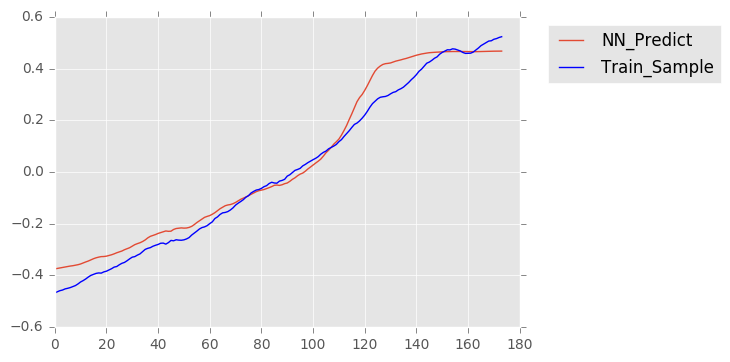

In [15]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

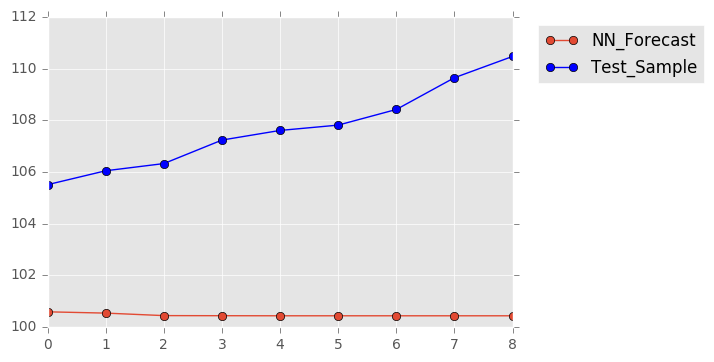

In [16]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [17]:
errors_out_sample(test, nn_forecast)

{'MAE': 7.2130879855685777, 'MSE': 54.552444802981682}

### Hybrid

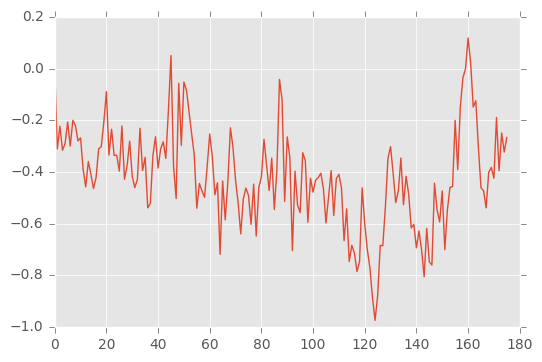

In [19]:
resids_arima = get_resids_arima(train, arima_model)
plt.plot(resids_arima)
plt.show()

In [20]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.0527
Epoch 2/100
0s - loss: 0.0362
Epoch 3/100
0s - loss: 0.0401
Epoch 4/100
0s - loss: 0.0331
Epoch 5/100
0s - loss: 0.0315
Epoch 6/100
0s - loss: 0.0322
Epoch 7/100
0s - loss: 0.0305
Epoch 8/100
0s - loss: 0.0293
Epoch 9/100
0s - loss: 0.0309
Epoch 10/100
0s - loss: 0.0290
Epoch 11/100
0s - loss: 0.0279
Epoch 12/100
0s - loss: 0.0318
Epoch 13/100
0s - loss: 0.0312
Epoch 14/100
0s - loss: 0.0305
Epoch 15/100
0s - loss: 0.0300
Epoch 16/100
0s - loss: 0.0292
Epoch 17/100
0s - loss: 0.0299
Epoch 18/100
0s - loss: 0.0301
Epoch 19/100
0s - loss: 0.0300
Epoch 20/100
0s - loss: 0.0292
Epoch 21/100
0s - loss: 0.0287
Epoch 22/100
0s - loss: 0.0309
Epoch 23/100
0s - loss: 0.0301
Epoch 24/100
0s - loss: 0.0295
Epoch 25/100
0s - loss: 0.0263
Epoch 26/100
0s - loss: 0.0269
Epoch 27/100
0s - loss: 0.0266
Epoch 28/100
0s - loss: 0.0268
Epoch 29/100
0s - loss: 0.0268
Epoch 30/100
0s - loss: 0.0253
Epoch 31/100
0s - loss: 0.0269
Epoch 32/100
0s - loss: 0.0283
Epoch 33/100
0s -

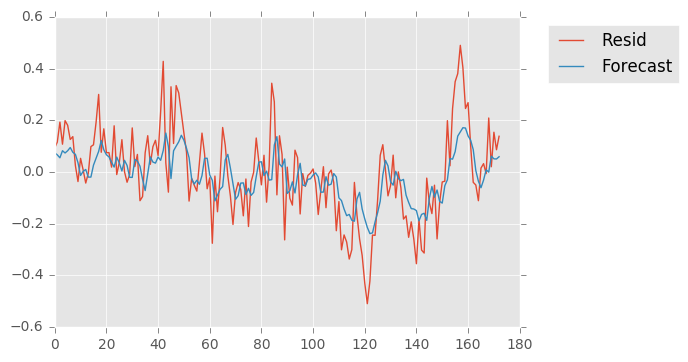

In [21]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [22]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

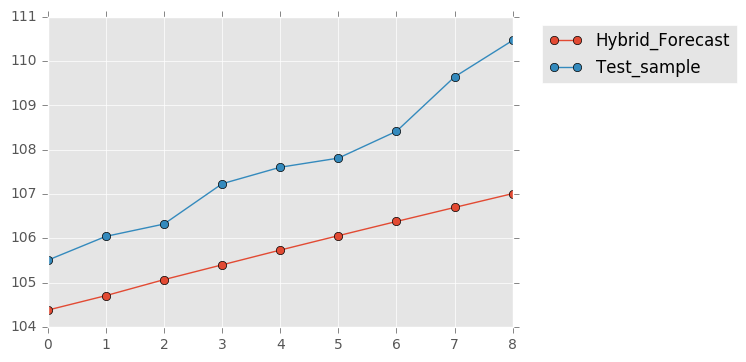

In [23]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [24]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 1.9576776558384807, 'MSE': 4.3745460538132948}

In [25]:
nn_resids_forecast

array([-0.676898  , -0.63642812, -0.57251853, -0.54108268, -0.51261252,
       -0.49351907, -0.47856379, -0.46775252, -0.4596462 ], dtype=float32)

---

---

---

# Saving and Investment by Sector

In [38]:
sav_inv_sec = df.iloc[63, 1:186].copy()
sav_inv_sec.index = pd.DatetimeIndex(start='1969-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   1.153398
p-value                          0.995648
#Lags Used                      14.000000
Number of Observations Used    170.000000
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
Critical Value (1%)             -3.469413
dtype: float64


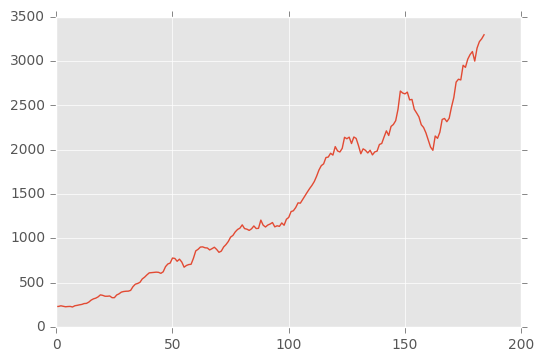

In [39]:
test_stationarity(sav_inv_sec)

Results of Dickey-Fuller Test:
Test Statistic                  -4.325188
p-value                          0.000402
#Lags Used                       3.000000
Number of Observations Used    180.000000
Critical Value (5%)             -2.877735
Critical Value (10%)            -2.575403
Critical Value (1%)             -3.467211
dtype: float64


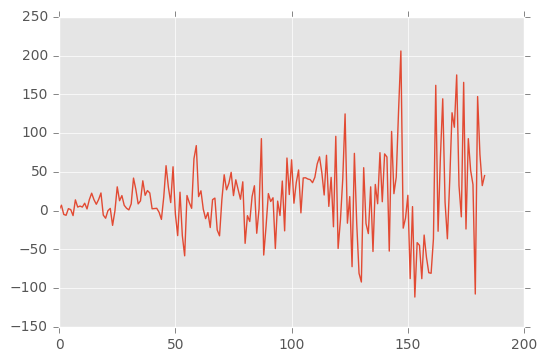

In [40]:
test_stationarity(diff_series(sav_inv_sec))

In [41]:
train = sav_inv_sec[:-9]
test = sav_inv_sec[-9:]

### ARIMA

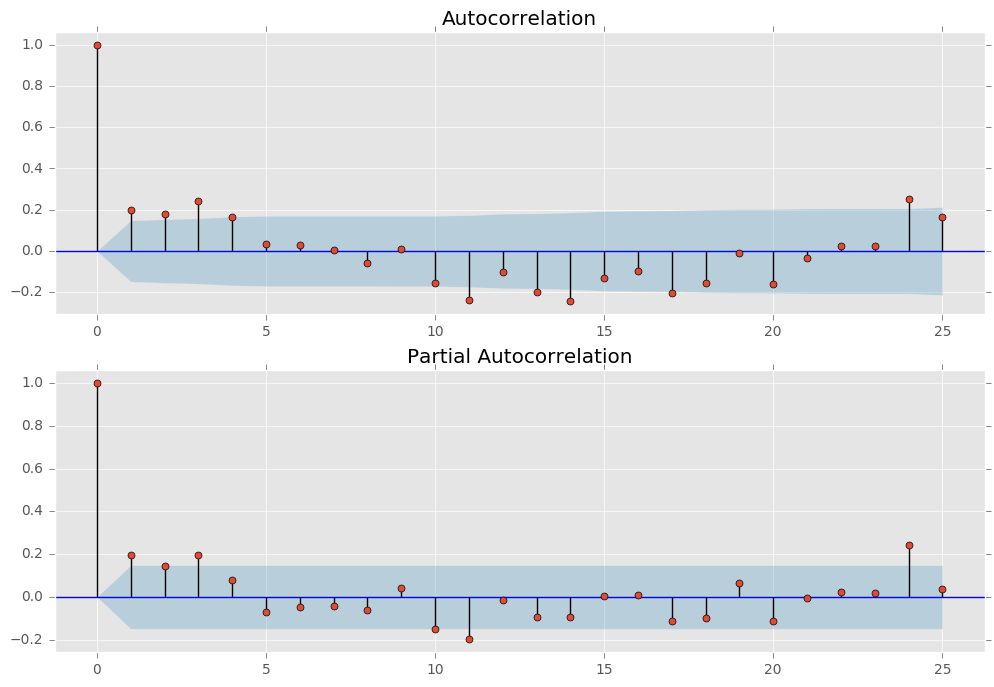

In [42]:
correlogram(diff_series(train))

In [49]:
arima_model = ARIMA(np.array(train), order=(1,1,1)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  175
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -922.201
Method:                       css-mle   S.D. of innovations             47.011
Date:                Sun, 29 Jan 2017   AIC                           1852.403
Time:                        03:24:25   BIC                           1865.062
Sample:                             1   HQIC                          1857.538
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         16.4022      6.765      2.425      0.016         3.144    29.661
ar.L1.D.y      0.7943      0.094      8.475      0.000         0.611     0.978
ma.L1.D.y     -0.6044      0.110     -5.486      0.0

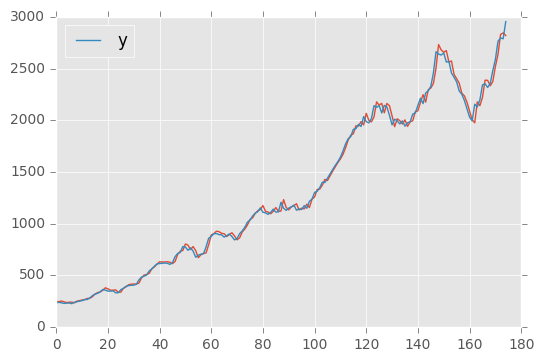

In [50]:
arima_model.plot_predict()
plt.show()

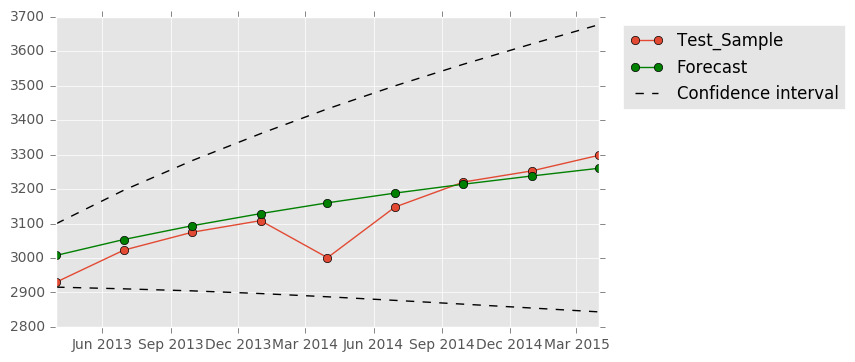

In [51]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

In [53]:
errors_out_sample(test, forc_arima[0])

{'MAE': 45.118882096290839, 'MSE': 4046.4860340727191}

### ANN

In [66]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.1047
Epoch 2/100
0s - loss: 0.0930
Epoch 3/100
0s - loss: 0.0911
Epoch 4/100
0s - loss: 0.0803
Epoch 5/100
0s - loss: 0.0836
Epoch 6/100
0s - loss: 0.0799
Epoch 7/100
0s - loss: 0.0768
Epoch 8/100
0s - loss: 0.0793
Epoch 9/100
0s - loss: 0.0749
Epoch 10/100
0s - loss: 0.0715
Epoch 11/100
0s - loss: 0.0689
Epoch 12/100
0s - loss: 0.0669
Epoch 13/100
0s - loss: 0.0555
Epoch 14/100
0s - loss: 0.0497
Epoch 15/100
0s - loss: 0.0433
Epoch 16/100
0s - loss: 0.0300
Epoch 17/100
0s - loss: 0.0364
Epoch 18/100
0s - loss: 0.0215
Epoch 19/100
0s - loss: 0.0288
Epoch 20/100
0s - loss: 0.0225
Epoch 21/100
0s - loss: 0.0245
Epoch 22/100
0s - loss: 0.0263
Epoch 23/100
0s - loss: 0.0207
Epoch 24/100
0s - loss: 0.0210
Epoch 25/100
0s - loss: 0.0167
Epoch 26/100
0s - loss: 0.0170
Epoch 27/100
0s - loss: 0.0197
Epoch 28/100
0s - loss: 0.0257
Epoch 29/100
0s - loss: 0.0210
Epoch 30/100
0s - loss: 0.0202
Epoch 31/100
0s - loss: 0.0184
Epoch 32/100
0s - loss: 0.0146
Epoch 33/100
0s -

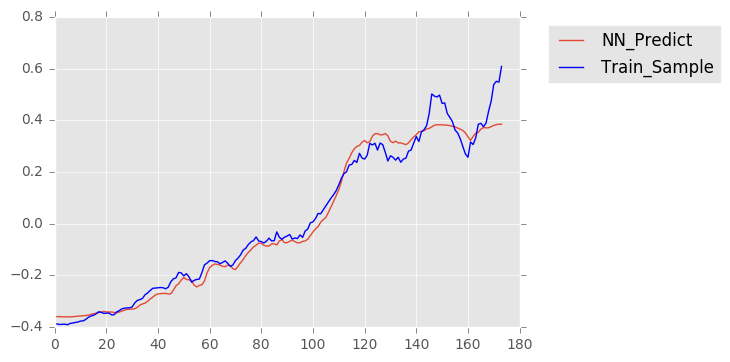

In [67]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

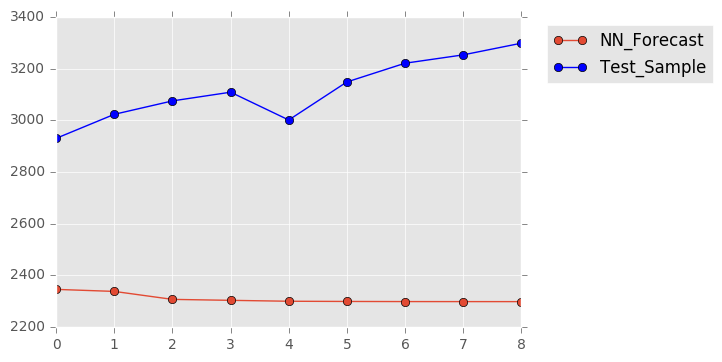

In [68]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [69]:
errors_out_sample(test, nn_forecast)

{'MAE': 808.18125542534733, 'MSE': 669951.27567990497}

### Hybrid

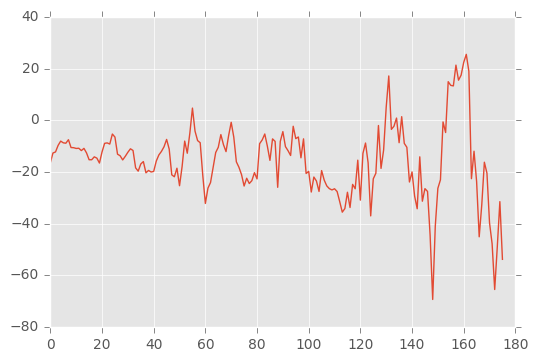

In [71]:
resids_arima = get_resids_arima(train, arima_model)
plt.plot(resids_arima)
plt.show()

In [72]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.2967
Epoch 2/100
0s - loss: 0.2027
Epoch 3/100
0s - loss: 0.1280
Epoch 4/100
0s - loss: 0.1102
Epoch 5/100
0s - loss: 0.0991
Epoch 6/100
0s - loss: 0.0599
Epoch 7/100
0s - loss: 0.0624
Epoch 8/100
0s - loss: 0.0499
Epoch 9/100
0s - loss: 0.0422
Epoch 10/100
0s - loss: 0.0419
Epoch 11/100
0s - loss: 0.0374
Epoch 12/100
0s - loss: 0.0347
Epoch 13/100
0s - loss: 0.0302
Epoch 14/100
0s - loss: 0.0318
Epoch 15/100
0s - loss: 0.0296
Epoch 16/100
0s - loss: 0.0287
Epoch 17/100
0s - loss: 0.0255
Epoch 18/100
0s - loss: 0.0236
Epoch 19/100
0s - loss: 0.0283
Epoch 20/100
0s - loss: 0.0232
Epoch 21/100
0s - loss: 0.0252
Epoch 22/100
0s - loss: 0.0244
Epoch 23/100
0s - loss: 0.0247
Epoch 24/100
0s - loss: 0.0232
Epoch 25/100
0s - loss: 0.0236
Epoch 26/100
0s - loss: 0.0234
Epoch 27/100
0s - loss: 0.0240
Epoch 28/100
0s - loss: 0.0233
Epoch 29/100
0s - loss: 0.0243
Epoch 30/100
0s - loss: 0.0239
Epoch 31/100
0s - loss: 0.0233
Epoch 32/100
0s - loss: 0.0235
Epoch 33/100
0s -

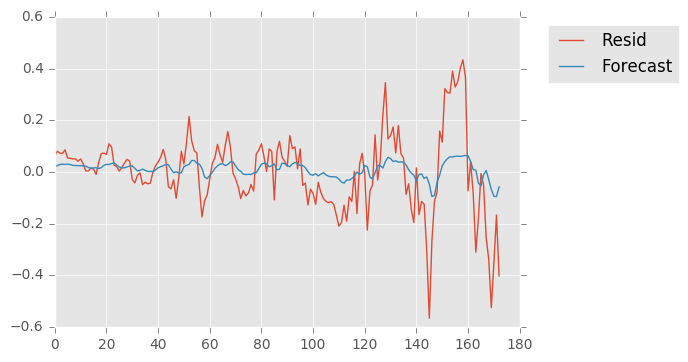

In [73]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [74]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

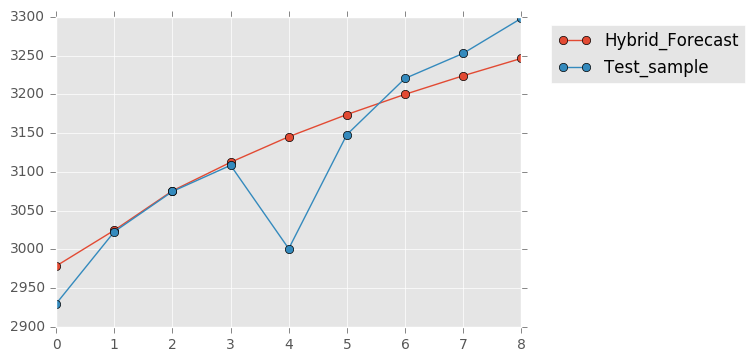

In [75]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [76]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 36.300565424707457, 'MSE': 3094.9613101830473}

In [77]:
nn_resids_forecast

array([-28.95257187, -28.95257187, -18.09087372, -16.47313881,
       -14.83150482, -14.42428493, -14.18290997, -14.1068716 , -14.07031441], dtype=float32)

---

---

---

# GDP in billions of current dollars  (Seasonally adjusted annual rates)

In [54]:
US_GDP = df.iloc[67, 1:274].copy()
US_GDP.index = pd.DatetimeIndex(start='1947-01', end='2015-04', freq='Q')

Results of Dickey-Fuller Test:
Test Statistic                   3.354483
p-value                          1.000000
#Lags Used                      11.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64


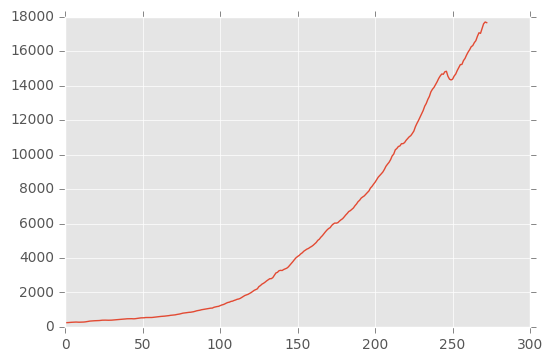

In [16]:
test_stationarity(US_GDP)

Results of Dickey-Fuller Test:
Test Statistic                  -1.720379
p-value                          0.420644
#Lags Used                      16.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64


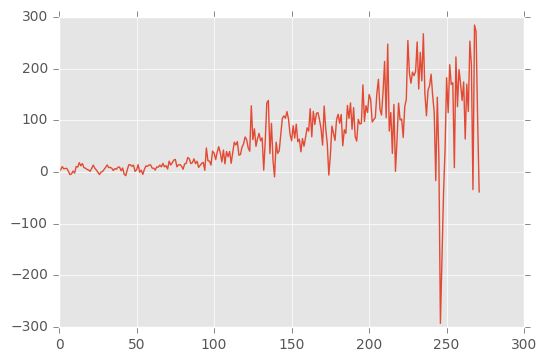

In [17]:
test_stationarity(diff_series(US_GDP))

Results of Dickey-Fuller Test:
Test Statistic                -6.915610e+00
p-value                        1.181648e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.560000e+02
Critical Value (1%)           -3.456155e+00
Critical Value (5%)           -2.872897e+00
Critical Value (10%)          -2.572822e+00
dtype: float64


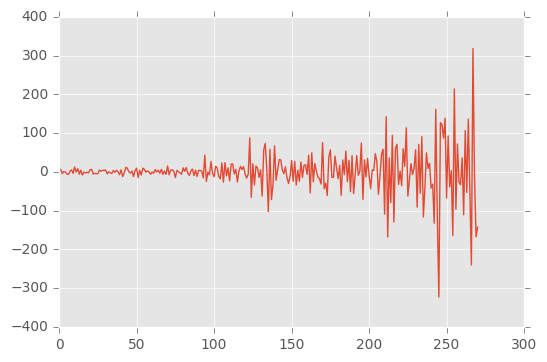

In [18]:
test_stationarity(diff_series(diff_series(US_GDP)))

In [55]:
train = US_GDP[:-9]
test = US_GDP[-9:]

### ARIMA

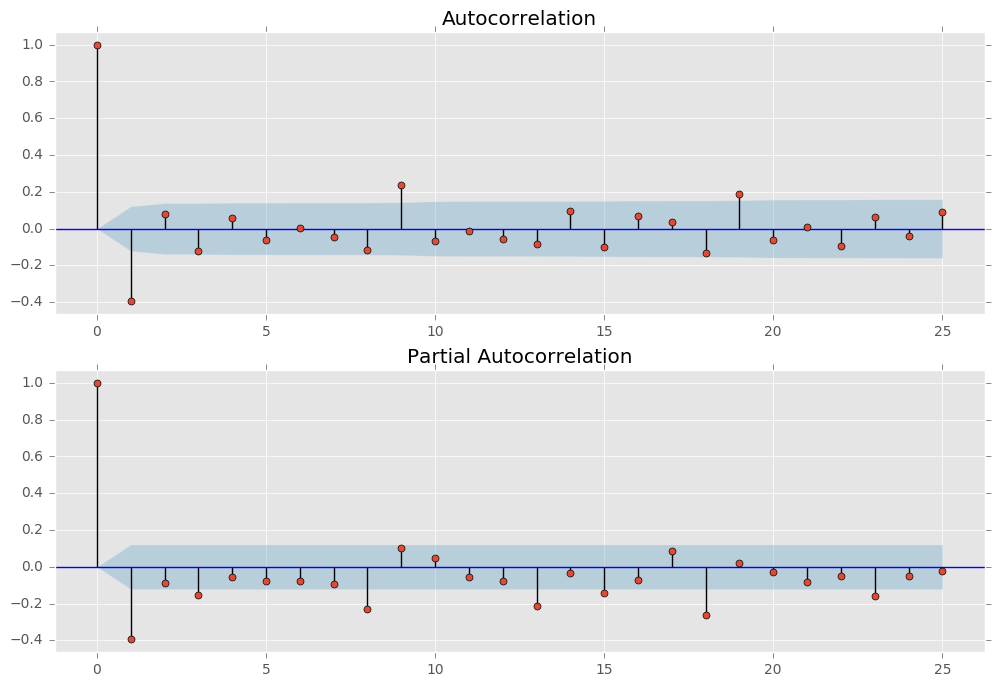

In [20]:
correlogram(diff_series(diff_series(train)))

In [56]:
arima_model = ARIMA(np.array(train), order=(2,2,1)).fit(trend='c')
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  262
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1357.383
Method:                       css-mle   S.D. of innovations             42.696
Date:                Tue, 31 Jan 2017   AIC                           2724.767
Time:                        01:28:02   BIC                           2742.608
Sample:                             2   HQIC                          2731.938
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5865      0.086      6.812      0.000         0.418     0.755
ar.L1.D2.y     0.4032      0.061      6.600      0.000         0.283     0.523
ar.L2.D2.y     0.2031      0.061      3.324      0.0

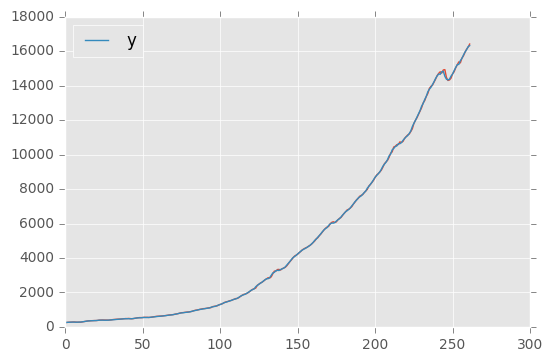

In [28]:
arima_model.plot_predict()
plt.show()

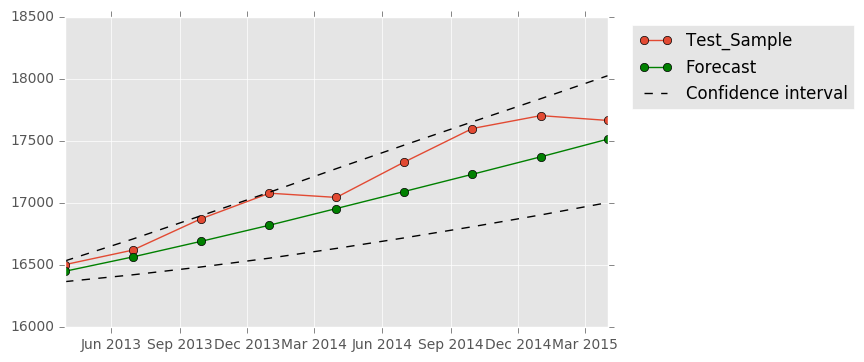

In [57]:
forc_arima = arima_model.forecast(len(test))
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1))

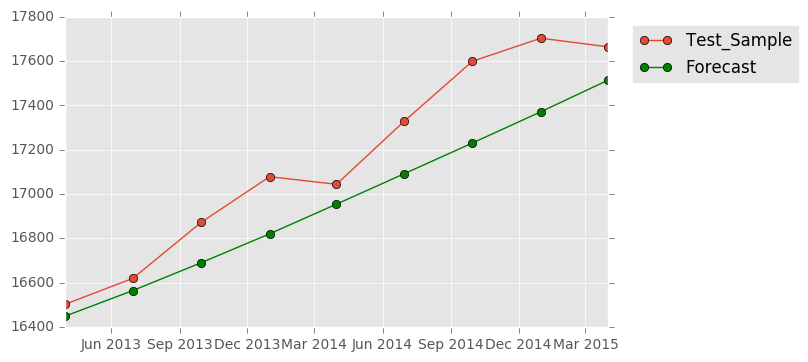

In [58]:
plot_forecast_out_only(test, forc_arima, bbox_loc=(1.03,1), conf_int=False)

In [58]:
errors_out_sample(test, forc_arima[0])

{'MAE': 191.99993071058594, 'MSE': 48816.477424064527}

### ANN

In [59]:
scaled_train = scaler(train)[0]

lags_for_nn = 2

train_nn = create_df_for_nn(scaled_train, lags_for_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = assemble_model(lags_for_nn)
nn.fit(np.array(train_nn.iloc[:, :-1]), 
       np.array(train_nn.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.1228
Epoch 2/100
0s - loss: 0.0935
Epoch 3/100
0s - loss: 0.0858
Epoch 4/100
0s - loss: 0.0688
Epoch 5/100
0s - loss: 0.0433
Epoch 6/100
0s - loss: 0.0149
Epoch 7/100
0s - loss: 0.0026
Epoch 8/100
0s - loss: 7.8511e-04
Epoch 9/100
0s - loss: 5.9209e-04
Epoch 10/100
0s - loss: 5.4384e-04
Epoch 11/100
0s - loss: 4.6637e-04
Epoch 12/100
0s - loss: 4.2530e-04
Epoch 13/100
0s - loss: 3.7212e-04
Epoch 14/100
0s - loss: 3.1819e-04
Epoch 15/100
0s - loss: 3.0875e-04
Epoch 16/100
0s - loss: 3.1168e-04
Epoch 17/100
0s - loss: 2.8864e-04
Epoch 18/100
0s - loss: 2.5198e-04
Epoch 19/100
0s - loss: 2.6103e-04
Epoch 20/100
0s - loss: 2.5283e-04
Epoch 21/100
0s - loss: 2.6435e-04
Epoch 22/100
0s - loss: 2.3605e-04
Epoch 23/100
0s - loss: 2.3343e-04
Epoch 24/100
0s - loss: 2.7943e-04
Epoch 25/100
0s - loss: 2.4546e-04
Epoch 26/100
0s - loss: 2.3312e-04
Epoch 27/100
0s - loss: 2.1477e-04
Epoch 28/100
0s - loss: 2.1806e-04
Epoch 29/100
0s - loss: 2.3211e-04
Epoch 30/100
0s - loss

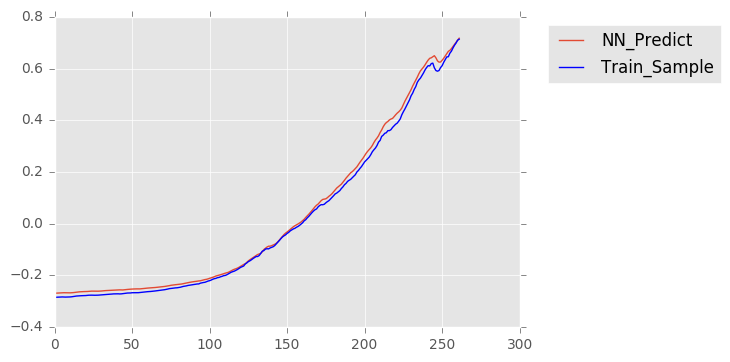

In [60]:
nn_plot_in_sample(nn, train_nn, bbox_loc=(1.45,1))

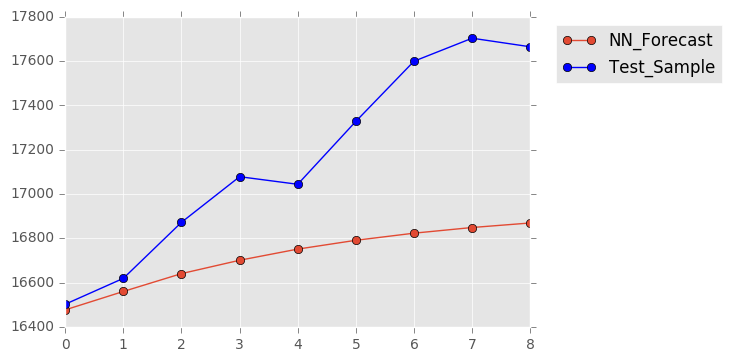

In [61]:
nn_scaled_forecast = nn_predict_series(nn, 
                                      last_obs_creator_nn(train_nn, lags_for_nn), 
                                      len(test))
nn_forecast = scaler_back(nn_scaled_forecast, scaler(train)[1], scaler(train)[2])

nn_plot_out_sample(nn_forecast, test, bbox_loc=(1.43,1))

In [63]:
errors_out_sample(test, nn_forecast)

{'MAE': 438.97673611111128, 'MSE': 282393.21164279513}

### Hybrid

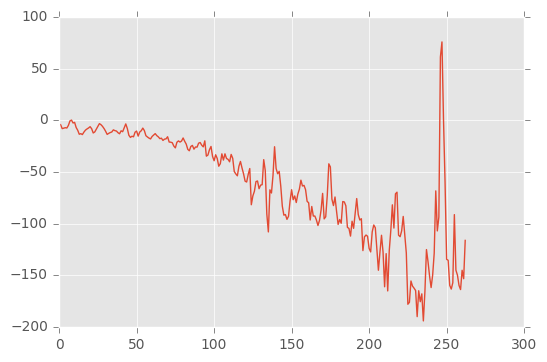

In [47]:
resids_arima = get_resids_arima(train, arima_model, d=2)
plt.plot(resids_arima)
plt.show()

In [48]:
scaled_resids_arima = scaler(resids_arima)[0]

lags_nn = 2

df_nn_resid = create_df_for_nn_residuals(scaled_resids_arima[1:], lags_nn)

def assemble_model(n_lags):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_lags, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(1, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn_resid = assemble_model(lags_nn)
nn_resid.fit(np.array(df_nn_resid.iloc[:, :-1]), 
       np.array(df_nn_resid.iloc[:, -1]), 
       nb_epoch=100, 
       verbose=2,
       batch_size=1)

Epoch 1/100
0s - loss: 0.1462
Epoch 2/100
0s - loss: 0.0516
Epoch 3/100
0s - loss: 0.0436
Epoch 4/100
0s - loss: 0.0391
Epoch 5/100
0s - loss: 0.0375
Epoch 6/100
0s - loss: 0.0391
Epoch 7/100
0s - loss: 0.0365
Epoch 8/100
0s - loss: 0.0367
Epoch 9/100
0s - loss: 0.0385
Epoch 10/100
0s - loss: 0.0351
Epoch 11/100
0s - loss: 0.0342
Epoch 12/100
0s - loss: 0.0348
Epoch 13/100
0s - loss: 0.0326
Epoch 14/100
0s - loss: 0.0320
Epoch 15/100
0s - loss: 0.0303
Epoch 16/100
0s - loss: 0.0282
Epoch 17/100
0s - loss: 0.0238
Epoch 18/100
0s - loss: 0.0230
Epoch 19/100
0s - loss: 0.0215
Epoch 20/100
0s - loss: 0.0180
Epoch 21/100
0s - loss: 0.0151
Epoch 22/100
0s - loss: 0.0158
Epoch 23/100
0s - loss: 0.0151
Epoch 24/100
0s - loss: 0.0165
Epoch 25/100
0s - loss: 0.0137
Epoch 26/100
0s - loss: 0.0166
Epoch 27/100
0s - loss: 0.0158
Epoch 28/100
0s - loss: 0.0115
Epoch 29/100
0s - loss: 0.0123
Epoch 30/100
0s - loss: 0.0143
Epoch 31/100
0s - loss: 0.0132
Epoch 32/100
0s - loss: 0.0140
Epoch 33/100
0s -

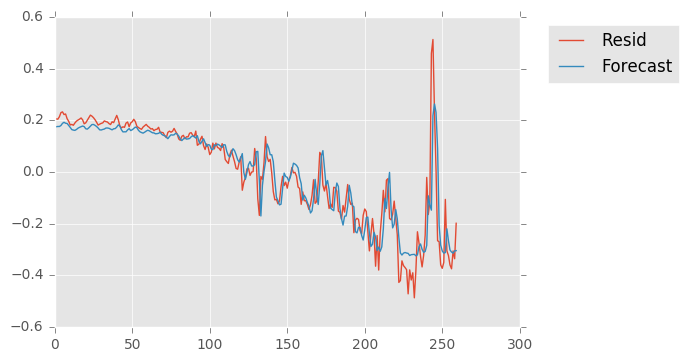

In [49]:
plt.plot(np.array(df_nn_resid.iloc[:, -1]), label='Resid')
plt.plot(nn_resid.predict(np.array(df_nn_resid.iloc[:, :-1])), label='Forecast')
plt.legend(bbox_to_anchor=(1.36,1), loc='best')
plt.show()

In [50]:
nn_scaled_resid_forecast = nn_predict_series(nn_resid, 
                                      last_lags_resid_df_for_nn(resids_arima, test, lags_nn), 
                                      len(test))

nn_resids_forecast = scaler_back(nn_scaled_resid_forecast, scaler(resids_arima)[1], scaler(resids_arima)[2])

hybrid_forecast = hybrid_predict_series(forc_arima, nn_resids_forecast)

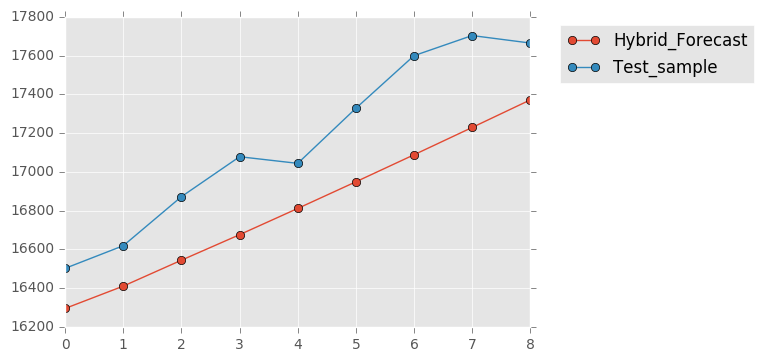

In [51]:
hybrid_plot_forecast(forc_arima, nn_resids_forecast, test)

In [52]:
errors_out_sample(test, hybrid_forecast)

{'MAE': 337.47834291490449, 'MSE': 125191.01710890055}

In [53]:
nn_resids_forecast

array([-153.45031738, -153.45031738, -145.62974548, -144.21218872,
       -143.06770325, -142.63150024, -142.38508606, -142.26942444,
       -142.20942688], dtype=float32)